# Define Classes, Libraries, and Global Variables that will be used across all simulations

In [1]:
import os
import random
from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
import pandas as pd
import simpy

class G:
    # Constants (adjust as needed)
    Process_Variance = 0.1
    UNLOADING_RATE = 60/15  # minutes per pallet
    UNLOADING_VARIANCE = Process_Variance  # 10% variance
    INDUCT_STAGE_RATE = 60/22  # minutes per pallet
    INDUCT_STAGE_VARIANCE = Process_Variance  # 10% variance
    INDUCTION_RATE = 60/800  # minutes per package
    INDUCTION_VARIANCE = Process_Variance  # 10% variance
    SPLITTER_RATE = 1/60  # minutes per package
    SPLITTER_VARIANCE = Process_Variance  # 10% variance
    TLMD_BUFFER_SORT_RATE = 60/148  # minutes per package
    TLMD_BUFFER_SORT_VARIANCE = Process_Variance  # 10% variance
    TLMD_PARTITION_STAGE_RATE = 1  # minutes per pallet
    TLMD_PARTITION_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_INDUCT_STAGE_RATE = 60/15  # minutes per pallet
    TLMD_INDUCT_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_INDUCTION_RATE = 60/300  # minutes per package
    TLMD_INDUCTION_VARIANCE = Process_Variance  # 10% variance
    TLMD_FINAL_SORT_RATE = 60/84  # minutes per package
    TLMD_FINAL_SORT_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_STAGE_RATE = 60/84  # minutes per cart
    TLMD_CART_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_HANDOFF_RATE = 60/22  # minutes per pallet
    TLMD_CART_HANDOFF_VARIANCE = Process_Variance  # 10% variance
    CART_STAGE_RATE = 2  # minutes per cart
    CART_STAGE_VARIANCE = Process_Variance  # 10% variance
    TLMD_CART_HANDOFF_RATE = 2  # minutes per cart
    TLMD_CART_HANDOFF_VARIANCE = Process_Variance  # 10% variance
    NATIONAL_CARRIER_SORT_RATE = 60/148  # minutes per package
    NATIONAL_CARRIER_SORT_VARIANCE = Process_Variance  # 10% variance
    NC_PALLET_STAGING_RATE = 60/120  # minutes per pallet
    NC_PALLET_STAGING_VARIANCE = Process_Variance  # 10% variance
    NATIONAL_CARRIER_FLUID_PICK_RATE = 1/60  # minutes per package
    NATIONAL_CARRIER_FLUID_PICK_VARIANCE = Process_Variance  # 10% variance
    NATIONAL_CARRIER_FLUID_LOAD_RATE = 60/120  # minutes per package
    NATIONAL_CARRIER_FLUID_LOAD_VARIANCE = Process_Variance  # 10% variance
    

    OUTBOUND_NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_CART_MAX_PACKAGES = 20  # Max packages per cart
    TOTAL_PACKAGES = None  # Total packages to be processed
    TOTAL_PACKAGES_TLMD = None  # Total TLMD packages to be processed
    TOTAL_PACKAGES_NC = None  # Total National Carrier packages to be processed
    TLMD_INDUCT_TIME = None
    TLMD_STAGED_PACKAGES = None
    TLMD_PARTITION_1_PACKAGES = None
    TLMD_PARTITION_2_PACKAGES = None
    TLMD_PARTITION_3_PACKAGES = None
    TLMD_PARTITION_1_SORT_TIME = None
    TLMD_PARTITION_2_SORT_TIME = None 
    TLMD_PARTITION_3_SORT_TIME = None
    TLMD_SORTED_PACKAGES = None
    TLMD_PARTITION_1_CART_STAGE_TIME = None
    TLMD_PARTITION_2_CART_STAGE_TIME = None 
    TLMD_PARTITION_3_CART_STAGE_TIME = None
    TLMD_OUTBOUND_PACKAGES = None
    I=1
    J=1
    K=1
    PASSED_OVER_PALLETS_1 = None
    PASSED_OVER_PALLETS_2 = None
    PASSED_OVER_PALLETS_3 = None

    TOTAL_PACKAGES_UPSN = None
    TOTAL_PACKAGES_USPS = None
    TOTAL_PACKAGES_FDEG = None
    TOTAL_PACKAGES_FDE = None
    UPSN_PALLETS = None
    USPS_PALLETS = None
    FDEG_PALLETS = None
    FDE_PALLETS = None
    UPSN_SORT_TIME = None
    USPS_SORT_TIME = None
    FDEG_SORT_TIME = None
    FDE_SORT_TIME = None

    TOTAL_SHIFT_PACKAGE_CARRYOVER = None
    TLMD_PALLET_PACKAGES_CARRYOVER = None
    TLMD_1_STAGED_PALLET_CARRYOVER = None
    TLMD_2_STAGED_PALLET_CARRYOVER = None
    TLMD_3_STAGED_PALLET_CARRYOVER = None
    TLMD_INDUCT_STAGING_PALLETS_CARRYOVER = None
    TLMD_INDUCT_STAGING_PACKAGES_CARRYOVER = None
    TLMD_SPLITTER_CARRYOVER = None
    TLMD_FINAL_SORT_CARRYOVER = None
    TLMD_CART_CARRYOVER = None

    PARTITION_1_RATIO = 0.50  # Ratio of packages to go to partition 1
    PARTITION_2_RATIO = 0.35  # Ratio of packages to go to partition 2
    PARTITION_3_RATIO = 0.15  # Ratio of packages to go to partition 3

    USPS_DEPARTURE_TIME = [780]  # minutes
    UPSN_DEPARTURE_TIME = [1440]  # minutes
    FDEG_DEPARTURE_TIME = [180, 390]  # minutes
    FDE_DEPARTURE_TIME = [330]  # minutes

class Package:
    def __init__(self, tracking_number, pallet_id, scac):
        self.tracking_number = tracking_number
        self.pallet_id = pallet_id
        self.scac = scac
        self.current_queue = None

class Pallet:
    def __init__(self, env, pallet_id, packages, pkg_received_utc_ts):
        self.env = env
        self.pkg_received_utc_ts = pkg_received_utc_ts
        self.pallet_id = pallet_id
        self.packages = [Package(pkg[0], pallet_id, pkg[1]) for pkg in packages]
        self.current_queue = None
        self.remaining_packages = len(packages)  # Track remaining packages

class TLMD_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f'Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}')
        print(f'Pallet currently contains {self.current_packages} packages')

class TLMD_Cart:
    def __init__(self, env, cart_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.cart_id = cart_id
        self.packages = packages
        self.current_packages = len(packages)  # Tracks packages
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to cart {self.cart_id} at {self.env.now}")
        print(f'Cart currently contains {self.current_packages} packages')

class National_Carrier_Pallet:
    def __init__(self, env, pallet_id, packages, scac, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.scac = scac
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')


def make_resources_unavailable(env, sortation_center, start, end):
    yield env.timeout(start)
    print(f'Resources unavailable at {env.now}')
    sortation_center.resources_available = False
    yield env.timeout(end - start)
    print(f'Resources available at {env.now}')
    sortation_center.resources_available = True

def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['resource_utilization'])
    plt.title('util')
    plt.xlabel('Time')
    plt.ylabel('util')
    plt.legend()
    plt.show()

    for queue, lengths in metrics['queue_lengths'].items():
        plt.figure(figsize=(12, 8))
        plt.plot(lengths, label=queue)
        plt.title('Queue Length')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')
        plt.legend()
        plt.show()

# Different Soration Center Process Classes

In [2]:
class Sortation_Center_Inbound:
    def __init__(self, 
                 env, 
                 pallets_df, 
                 tm_pit_unload, 
                 tm_pit_induct, 
                 tm_nonpit_split, 
                 tm_nonpit_NC, 
                 tm_nonpit_buffer, 
                 Fluid_status):
        
        self.env = env
        self.pallets_df = pallets_df
        self.tm_pit_unload = simpy.Resource(env, capacity=tm_pit_unload)
        self.tm_pit_induct = simpy.PriorityResource(env, capacity=tm_pit_induct)
        self.tm_nonpit_split = simpy.Resource(env, capacity=tm_nonpit_split)
        self.tm_nonpit_NC = simpy.PriorityResource(env, capacity=tm_nonpit_NC)
        self.tm_nonpit_buffer = simpy.PriorityResource(env, capacity=tm_nonpit_buffer)
        self.Fluid_status = Fluid_status
        self.resources_available = True

        self.USPS_flag = False
        self.UPSN_flag = False
        self.FDEG_flag = False
        self.FDE_flag = False

        self.queues = {
            'queue_inbound_truck': simpy.Store(self.env),
            'queue_inbound_staging': simpy.Store(self.env, capacity=200),
            'queue_induct_staging_pallets': simpy.Store(self.env, capacity=10),
            'queue_induct_staging_packages': simpy.Store(self.env),
            'queue_splitter': simpy.Store(self.env, capacity=1),
            'queue_tlmd_buffer_sort': simpy.Store(self.env, capacity=100000),
            'queue_national_carrier_sort': simpy.Store(self.env, capacity=100000),
            'queue_tlmd_pallet': simpy.Store(self.env, capacity=100000),
            "queue_FDEG_pallet": simpy.Store(self.env),
            "queue_FDE_pallet": simpy.Store(self.env),
            "queue_USPS_pallet": simpy.Store(self.env),
            "queue_UPSN_pallet": simpy.Store(self.env), 
            'queue_FDEG_staged_pallet': simpy.Store(self.env),
            'queue_FDE_staged_pallet': simpy.Store(self.env),
            'queue_USPS_staged_pallet': simpy.Store(self.env),
            'queue_UPSN_staged_pallet': simpy.Store(self.env),
            "queue_FDEG_fluid": simpy.Store(self.env, capacity=10),
            "queue_FDE_fluid": simpy.Store(self.env, capacity=10),
            "queue_USPS_fluid": simpy.Store(self.env, capacity=10),
            "queue_UPSN_fluid": simpy.Store(self.env, capacity=10),
            'queue_FDEG_outbound_packages': simpy.Store(self.env),
            'queue_FDE_outbound_packages': simpy.Store(self.env),
            'queue_USPS_outbound_packages': simpy.Store(self.env),
            'queue_UPSN_outbound_packages': simpy.Store(self.env),
        }

        self.metrics = {
            'processing_times': [],
            'queue_lengths': {key: [] for key in self.queues.keys()},
            'resource_utilization': [],
        }

        self.all_packages_staged_time = None

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics['queue_lengths'][key].append(len(queue.items))
            self.metrics['resource_utilization'].append(len(self.tm_pit_unload.queue))
            yield self.env.timeout(1)

    def schedule_arrivals(self):
        for i, row in self.pallets_df.iterrows():
            pallet = Pallet(
                self.env,
                row['Pallet'],
                row['packages'],
                row['earliest_arrival']
            )
            self.env.process(self.truck_arrival(pallet))

    def truck_arrival(self, pallet):
        yield self.env.timeout(pallet.pkg_received_utc_ts)  # Arrival time
        pallet.current_queue = 'queue_inbound_truck'
        print(f'Pallet {pallet.pallet_id} arrived at {self.env.now}')
        yield self.queues['queue_inbound_truck'].put(pallet)
        self.env.process(self.unload_truck(pallet))

    def unload_truck(self, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        
        with self.tm_pit_unload.request() as req:
            yield req
            yield self.queues['queue_inbound_truck'].get()
            yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
            pallet.current_queue = 'queue_inbound_staging'
            print(f'Pallet {pallet.pallet_id} unloaded at {self.env.now}')
            yield self.queues['queue_inbound_staging'].put(pallet)
            self.env.process(self.move_to_induct_staging(pallet))

    def move_to_induct_staging(self, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit

        print('TEST1')
        print(f'available pit induct resources: {self.tm_pit_induct.count}')

        with self.tm_pit_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues['queue_inbound_staging'].get()
            yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = 'queue_induct_staging_pallets'
            yield self.queues['queue_induct_staging_pallets'].put(pallet)
            print(f'Pallet {pallet.pallet_id} staged for induction at {self.env.now}')
            for package in pallet.packages:
                package.current_queue = 'queue_induct_staging_packages'
                yield self.queues['queue_induct_staging_packages'].put(package)
                self.env.process(self.induct_package(package, pallet))

    def induct_package(self, package, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_pit_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues['queue_induct_staging_packages'].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = 'queue_splitter'
            print(f'Package {package.tracking_number}, {package.scac} inducted at {self.env.now}')
            yield self.queues['queue_splitter'].put(package)
            pallet.remaining_packages -= 1  # Decrement the counter
            if pallet.remaining_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.split_package(package))

    def remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues['queue_induct_staging_pallets'].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues['queue_induct_staging_pallets'].items[i]
                print(f'Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}')
                break

    def split_package(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_nonpit_split.request() as req:
            yield req
            yield self.queues['queue_splitter'].get()
            if package.scac in ['UPSN', 'USPS', 'FDEG', 'FDE']:
                package.current_queue = 'queue_national_carrier_sort'
                print(f'Package {package.tracking_number} split to National Sort at {self.env.now}')
                yield self.queues['queue_national_carrier_sort'].put(package)
                self.env.process(self.national_carrier_sort(package))
            else:
                package.current_queue = 'queue_tlmd_buffer_sort'
                print(f'Package {package.tracking_number} split to TLMD Buffer at {self.env.now}')
                yield self.queues['queue_tlmd_buffer_sort'].put(package)
                self.env.process(self.tlmd_buffer_sort(package))

    def national_carrier_sort(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_national_carrier_sort"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
            
            if package.scac in ['UPSN']:
                if not self.Fluid_status:
                    yield self.queues["queue_UPSN_pallet"].put(package)
                    self.env.process(self.check_all_UPSN_sorted())
                else:
                    yield self.queues["queue_UPSN_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_UPSN(package))
            elif package.scac in ['USPS']:
                if not self.Fluid_status:
                    yield self.queues["queue_USPS_pallet"].put(package)
                    self.env.process(self.check_all_USPS_sorted())
                else:
                    yield self.queues["queue_USPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_USPS(package))
            elif package.scac in ['FDEG']:
                if not self.Fluid_status:
                    yield self.queues["queue_FDEG_pallet"].put(package)
                    self.env.process(self.check_all_FDEG_sorted())
                else:
                    yield self.queues["queue_FDEG_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDEG(package))
            elif package.scac in ['FDE']:
                if not self.Fluid_status:
                    yield self.queues["queue_FDE_pallet"].put(package)
                    self.env.process(self.check_all_FDE_sorted())
                else:
                    yield self.queues["queue_FDE_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDE(package))

    def check_all_UPSN_sorted(self):
        if len(self.queues['queue_UPSN_pallet'].items) == G.TOTAL_PACKAGES_UPSN:
            print(f'All UPSN packages sorted at {self.env.now}')
            G.UPSN_SORT_TIME = self.env.now 
            self.env.process(self.NC_UPSN_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_UPSN_sorted())

    def check_all_USPS_sorted(self):
        if len(self.queues['queue_USPS_pallet'].items) == G.TOTAL_PACKAGES_USPS:
            print(f'All USPS packages sorted at {self.env.now}')
            G.USPS_SORT_TIME = self.env.now
            self.env.process(self.NC_USPS_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_USPS_sorted())

    def check_all_FDEG_sorted(self):
        if  len(self.queues['queue_FDEG_pallet'].items) == G.TOTAL_PACKAGES_FDEG:
            print(f'All FDEG packages sorted at {self.env.now}')
            G.FDEG_SORT_TIME = self.env.now
            self.env.process(self.NC_FDEG_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_FDEG_sorted())

    def check_all_FDE_sorted(self):
        if  len(self.queues['queue_FDE_pallet'].items) == G.TOTAL_PACKAGES_FDE:
            print(f'All FDE packages sorted at {self.env.now}')
            G.FDE_SORT_TIME = self.env.now
            self.env.process(self.NC_FDE_pallet_build())
        else:
            yield self.env.timeout(1)
            self.env.process(self.check_all_FDE_sorted())            

    def NC_UPSN_pallet_build(self):
        UPSN_pallets = math.ceil(G.TOTAL_PACKAGES_UPSN / G.NC_PALLET_MAX_PACKAGES)
        print(f'UPSN: {UPSN_pallets} pallets')
        G.UPSN_PALLETS = UPSN_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            with self.tm_nonpit_NC.request(priority=0) as req:
                yield req
                remaining_packages = NC_packages
            
                for pallet_num in range(NC_pallets):
                    pallet_packages = []
                    packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                    
                    for _ in range(packages_for_this_pallet):
                        pkg = yield self.queues[queue_name].get()
                        pallet_packages.append(pkg)
                        yield self.env.timeout(0)
                    
                    pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                    G.K += 1
                    print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                    
                    yield self.queues[staged_queue_name].put(pallet)
                    yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                    
                    remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_UPSN, UPSN_pallets, 'queue_UPSN_pallet', 'queue_UPSN_staged_pallet','UPSN'))

    def NC_USPS_pallet_build(self):
        USPS_pallets = math.ceil(G.TOTAL_PACKAGES_USPS / G.NC_PALLET_MAX_PACKAGES)
        print(f'USPS: {USPS_pallets} pallets')
        G.USPS_PALLETS = USPS_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            with self.tm_nonpit_NC.request(priority=0) as req:
                yield req
                remaining_packages = NC_packages
            
                for pallet_num in range(NC_pallets):
                    pallet_packages = []
                    packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                    
                    for _ in range(packages_for_this_pallet):
                        pkg = yield self.queues[queue_name].get()
                        pallet_packages.append(pkg)
                        yield self.env.timeout(0)
                    
                    pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                    G.K += 1
                    print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                    
                    yield self.queues[staged_queue_name].put(pallet)
                    yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                    
                    remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_USPS, USPS_pallets, 'queue_USPS_pallet', 'queue_USPS_staged_pallet','USPS'))


    def NC_FDEG_pallet_build(self):
        FDEG_pallets = math.ceil(G.TOTAL_PACKAGES_FDEG / G.NC_PALLET_MAX_PACKAGES)
        print(f'FDEG: {FDEG_pallets} pallets')
        G.FDEG_PALLETS = FDEG_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            with self.tm_nonpit_NC.request(priority=0) as req:
                yield req
                remaining_packages = NC_packages
            
                for pallet_num in range(NC_pallets):
                    pallet_packages = []
                    packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                    
                    for _ in range(packages_for_this_pallet):
                        pkg = yield self.queues[queue_name].get()
                        pallet_packages.append(pkg)
                        yield self.env.timeout(0)
                    
                    pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                    G.K += 1
                    print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                    
                    yield self.queues[staged_queue_name].put(pallet)
                    yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                    
                    remaining_packages -= packages_for_this_pallet


        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_FDEG, FDEG_pallets, 'queue_FDEG_pallet', 'queue_FDEG_staged_pallet','FDEG'))


    def NC_FDE_pallet_build(self):
        FDE_pallets = math.ceil(G.TOTAL_PACKAGES_FDE / G.NC_PALLET_MAX_PACKAGES)
        print(f'FDE: {FDE_pallets} pallets')
        G.FDE_PALLETS = FDE_pallets

        def create_NC_pallets(NC_packages, NC_pallets, queue_name, staged_queue_name, scac):
            with self.tm_nonpit_NC.request(priority=0) as req:
                yield req
                remaining_packages = NC_packages
            
                for pallet_num in range(NC_pallets):
                    pallet_packages = []
                    packages_for_this_pallet = min(G.NC_PALLET_MAX_PACKAGES, remaining_packages)
                    
                    for _ in range(packages_for_this_pallet):
                        pkg = yield self.queues[queue_name].get()
                        pallet_packages.append(pkg)
                        yield self.env.timeout(0)
                    
                    pallet = National_Carrier_Pallet(self.env, f'Pallet_{G.K}', pallet_packages, scac, self.env.now)
                    G.K += 1
                    print(f'NC_{scac}, {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                    
                    yield self.queues[staged_queue_name].put(pallet)
                    yield self.env.timeout(G.NC_PALLET_STAGING_RATE)
                    
                    remaining_packages -= packages_for_this_pallet

        yield self.env.process(create_NC_pallets(G.TOTAL_PACKAGES_FDE, FDE_pallets, 'queue_FDE_pallet', 'queue_FDE_staged_pallet','FDE'))

########################################################
##### Begin National Carrier Fluid Load Process#########
########################################################

    def national_carrier_fluid_split_UPSN(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPSN_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to UPSN fluid at {self.env.now}")
            yield self.queues["queue_UPSN_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_UPSN(package))

    def national_carrier_fluid_load_UPSN(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPSN_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to UPSN at {self.env.now}")
            yield self.queues["queue_UPSN_Outbound"].put(package)


    def national_carrier_fluid_split_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
            yield self.queues["queue_USPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_USPS(package))

    def national_carrier_fluid_load_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
            yield self.queues["queue_USPS_Outbound"].put(package)


    def national_carrier_fluid_split_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
            yield self.queues["queue_FDEG_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDEG(package))

    def national_carrier_fluid_load_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
            yield self.queues["queue_FDEG_Outbound"].put(package)


    def national_carrier_fluid_split_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
            yield self.queues["queue_FDE_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDE(package))

    def national_carrier_fluid_load_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
            yield self.queues["queue_FDE_Outbound"].put(package)


    ########################################################
    ############## Begin TLMD Sort Process #################
    ########################################################
    
    # this will need to be updated to include the logic associated with the different partitions
    def tlmd_buffer_sort(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_nonpit_buffer.request(priority=1) as req:
            yield req
            yield self.queues['queue_tlmd_buffer_sort'].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f'Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}')
            yield self.queues['queue_tlmd_pallet'].put(package)
            self.check_all_packages_staged()
       
    #determine if queue_tlmd_staged_pallet holds the same number of packages as total_packages and if so, record the time
    def check_all_packages_staged(self):
        if len(self.queues['queue_tlmd_pallet'].items) == G.TOTAL_PACKAGES_TLMD:
            self.all_packages_staged_time = self.env.now
            G.TLMD_INDUCT_TIME = self.all_packages_staged_time
            print(f'All packages staged at {self.all_packages_staged_time}')
            G.TLMD_STAGED_PACKAGES = self.queues['queue_tlmd_pallet'].items

    def run_simulation(self, until):
        ############################
        #Add mechanism to capture the remaining packages due to inadequate time to process all packages
        if self.env.now == until:
            print('Simulation ended due to time limit')
            self.env.exit()
        return self.env.timeout(until)


class Sortation_Center_TLMD:
    def __init__(self, 
                env, 
                packages_df, 
                tm_TLMD_induct,
                tm_TLMD_picker,
                tm_TLMD_sort, 
                ):
        
        self.env = env
        self.packages_df = packages_df
        self.tm_TLMD_induct = simpy.PriorityResource(env, capacity=tm_TLMD_induct)
        self.tm_TLMD_picker = simpy.Resource(env, capacity=tm_TLMD_picker)
        self.tm_TLMD_sort = simpy.Resource(env, capacity=tm_TLMD_sort)
        self.resources_available = True


        self.partition_1_flag = False
        self.partition_2_flag = False
        self.partition_3_flag = False
        self.dedicate_to_cart_staging = False

        self.queues = {
                        'queue_tlmd_pallet_packages': simpy.Store(env),
                        'queue_tlmd_1_staged_pallet': simpy.Store(env),
                        'queue_tlmd_2_staged_pallet': simpy.Store(env),
                        'queue_tlmd_3_staged_pallet': simpy.Store(env),
                        'queue_tlmd_induct_staging_pallets' : simpy.Store(env, capacity=6),
                        'queue_tlmd_induct_staging_packages' : simpy.Store(env),
                        'queue_tlmd_splitter' : simpy.Store(env),
                        'queue_tlmd_final_sort' : simpy.Store(env),
                        'queue_tlmd_cart' : simpy.Store(env)  
                        }

        for item in G.TLMD_STAGED_PACKAGES:
            self.queues['queue_tlmd_pallet_packages'].put(item)

        self.metrics = {
            'processing_times': [],
            'queue_lengths': {key: [] for key in self.queues.keys()},
            'resource_utilization': [],
            }

        self.all_packages_staged_time = None

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics['queue_lengths'][key].append(len(queue.items))
            yield self.env.timeout(1)


    #Generate the stock of packages that resulted from the previous simulation.

    def TLMD_pallet_build(self):
    # Calculate the number of packages in each partition
        partition_1_packages = round(G.PARTITION_1_RATIO * G.TOTAL_PACKAGES_TLMD)
        partition_2_packages = round(G.PARTITION_2_RATIO * G.TOTAL_PACKAGES_TLMD)
        partition_3_packages = round(G.PARTITION_3_RATIO * G.TOTAL_PACKAGES_TLMD)

        G.TLMD_PARTITION_1_PACKAGES = partition_1_packages
        G.TLMD_PARTITION_2_PACKAGES = partition_2_packages
        G.TLMD_PARTITION_3_PACKAGES = partition_3_packages
    
        
        print(f'Partition 1: {partition_1_packages} packages')
        print(f'Partition 2: {partition_2_packages} packages')
        print(f'Partition 3: {partition_3_packages} packages')
        print(f'Total packages: {partition_1_packages + partition_2_packages + partition_3_packages}')
        
        # Handle any rounding discrepancies
        if partition_1_packages + partition_2_packages + partition_3_packages != G.TOTAL_PACKAGES_TLMD:
            partition_1_packages += G.TOTAL_PACKAGES_TLMD - (partition_1_packages + partition_2_packages + partition_3_packages)
            print(f'Adjusted Partition 1: {partition_1_packages} packages')

        # Calculate the number of pallets needed for each partition
        partition_1_pallets = math.ceil(partition_1_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)
        partition_2_pallets = math.ceil(partition_2_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)
        partition_3_pallets = math.ceil(partition_3_packages / G.TLMD_PARTITION_PALLET_MAX_PACKAGES)

        # Function to create pallets for a given partition
        def create_pallets(partition_packages, partition_pallets, queue_name, staged_queue_name):
            remaining_packages = partition_packages
            
            for pallet_num in range(partition_pallets):
                pallet_packages = []
                
                # Calculate how many packages should go on this pallet (handle last pallet separately)
                packages_for_this_pallet = min(G.TLMD_PARTITION_PALLET_MAX_PACKAGES, remaining_packages)
                
                # Fetch exactly the required number of packages from the queue
                for _ in range(packages_for_this_pallet):
                    pkg = yield self.queues[queue_name].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(0)
                
                # Create and stage the pallet
                pallet = TLMD_Pallet(self.env, f'Pallet_{G.I}', pallet_packages, self.env.now)
                G.I += 1
                print(f'TLMD {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}')
                
                # Move pallet to the staged queue
                yield self.queues[staged_queue_name].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.feed_TLMD_induct_staging(pallet))
                
                # Reduce remaining packages count
                remaining_packages -= packages_for_this_pallet

        # Create pallets for each partition
        yield self.env.process(create_pallets(partition_1_packages, partition_1_pallets, 'queue_tlmd_pallet_packages', 'queue_tlmd_1_staged_pallet'))
        yield self.env.process(create_pallets(partition_2_packages, partition_2_pallets, 'queue_tlmd_pallet_packages', 'queue_tlmd_2_staged_pallet'))
        yield self.env.process(create_pallets(partition_3_packages, partition_3_pallets, 'queue_tlmd_pallet_packages', 'queue_tlmd_3_staged_pallet'))



    def feed_TLMD_induct_staging(self,pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_TLMD_induct.request(priority=1) as req:  # Lower priority
            yield req
            if len(self.queues['queue_tlmd_1_staged_pallet'].items) > 0:
                yield self.queues['queue_tlmd_1_staged_pallet'].get()
            elif len(self.queues['queue_tlmd_2_staged_pallet'].items) > 0:
                yield self.queues['queue_tlmd_2_staged_pallet'].get()
            else:
                yield self.queues['queue_tlmd_3_staged_pallet'].get()

            yield self.env.timeout(G.TLMD_INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = 'queue_tlmd_induct_staging_pallets'
            yield self.queues['queue_tlmd_induct_staging_pallets'].put(pallet)
            print(f'Pallet {pallet.pallet_id} staged for TLMD induction at {self.env.now}')
            for package in pallet.packages:
                package.current_queue = 'queue_tlmd_induct_staging_packages'
                yield self.queues['queue_tlmd_induct_staging_packages'].put(package)
                self.env.process(self.tlmd_induct_package(package, pallet))


    def tlmd_induct_package(self, package, pallet):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_TLMD_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues['queue_tlmd_induct_staging_packages'].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = 'queue_tlmd_splitter'
            print(f'Package {package.tracking_number}, {package.scac} inducted at TLMD at {self.env.now}')
            yield self.queues['queue_tlmd_splitter'].put(package)
            pallet.current_packages -= 1  # Decrement the counter
            if pallet.current_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.tlmd_remove_pallet_from_queue(pallet)
            self.env.process(self.tlmd_lane_pickoff(package))

    def tlmd_remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues['queue_tlmd_induct_staging_pallets'].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues['queue_tlmd_induct_staging_pallets'].items[i]
                print(f'Pallet {pallet.pallet_id} removed from queue_tlmd_induct_staging_pallets at {self.env.now}')
                break

    #Will need to include logic to split based on the different lanes
    
    def tlmd_lane_pickoff(self, package):
        while not self.resources_available:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_TLMD_picker.request() as req:
            yield req
            yield self.queues['queue_tlmd_splitter'].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            package.current_queue = 'queue_tlmd_final_sort'
            print(f'Package {package.tracking_number} split to TLMD Final Sort at {self.env.now}')
            yield self.queues['queue_tlmd_final_sort'].put(package)
            self.env.process(self.tlmd_final_sort(package))

    # will need to include logic to sort to specific carts based on lane designation
    def tlmd_final_sort(self, package):
        while not self.resources_available or self.dedicate_to_cart_staging:
            yield self.env.timeout(1)  # Check every 1 time unit
        with self.tm_TLMD_sort.request() as req:
            yield req
            yield self.queues['queue_tlmd_final_sort'].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f'Package {package.tracking_number} sorted to TLMD Cart at {self.env.now}')
            yield self.queues['queue_tlmd_cart'].put(package)
            print(f'Total packages sorted: {len(self.queues["queue_tlmd_cart"].items)}')
            self.check_all_TLMD_sorted()

    def check_all_TLMD_sorted(self):
        if (
            not self.partition_1_flag
            and len(self.queues['queue_tlmd_1_staged_pallet'].items) == 0
            and len(self.queues['queue_tlmd_cart'].items) > G.TLMD_PARTITION_1_PACKAGES
        ):
                all_packages_staged_time_1 = self.env.now
                G.TLMD_PARTITION_1_SORT_TIME = all_packages_staged_time_1
                print(f'All partition 1 packages sorted at {all_packages_staged_time_1}')
                self.partition_1_flag = True  # Mark this partition as handled

        # Check for partition 2 only if partition 1 is done
        elif (
            not self.partition_2_flag
            and self.partition_1_flag  # Ensure partition 1 is done
            and len(self.queues['queue_tlmd_2_staged_pallet'].items) == 0
            and len(self.queues['queue_tlmd_cart'].items) > G.TLMD_PARTITION_2_PACKAGES + G.TLMD_PARTITION_1_PACKAGES
        ):
            all_packages_staged_time_2 = self.env.now
            G.TLMD_PARTITION_2_SORT_TIME = all_packages_staged_time_2
            print(f'All partition 2 packages sorted at {all_packages_staged_time_2}')
            self.partition_2_flag = True  # Mark this partition as handled

        # Check for partition 3 only if partition 2 is done
        elif (
            not self.partition_3_flag
            and self.partition_2_flag  # Ensure partition 2 is done
            and len(self.queues['queue_tlmd_cart'].items) >= G.TLMD_PARTITION_3_PACKAGES + G.TLMD_PARTITION_2_PACKAGES + G.TLMD_PARTITION_1_PACKAGES
        ):
            all_packages_staged_time_3 = self.env.now
            G.TLMD_PARTITION_3_SORT_TIME = all_packages_staged_time_3
            print(f'All partition 3 packages sorted at {all_packages_staged_time_3}')
            self.partition_3_flag = True  # Mark this partition as handled

        # Check if all partitions are done
        if self.partition_1_flag and self.partition_2_flag and self.partition_3_flag:
            G.TLMD_SORTED_PACKAGES = self.queues['queue_tlmd_cart'].items
            print(f'All {len(G.TLMD_SORTED_PACKAGES)} TLMD packages sorted at {self.env.now}')
        
        else:
            G.PASSED_OVER_PALLETS_1 = self.queues['queue_tlmd_1_staged_pallet'].items
            G.PASSED_OVER_PALLETS_2 = self.queues['queue_tlmd_2_staged_pallet'].items
            G.PASSED_OVER_PALLETS_3 = self.queues['queue_tlmd_3_staged_pallet'].items
            G.TLMD_PALLET_PACKAGES_CARRYOVER = self.queues['queue_tlmd_pallet_packages']
            G.TLMD_1_STAGED_PALLET_CARRYOVER = self.queues['queue_tlmd_1_staged_pallet']
            G.TLMD_2_STAGED_PALLET_CARRYOVER = self.queues['queue_tlmd_2_staged_pallet']
            G.TLMD_3_STAGED_PALLET_CARRYOVER = self.queues['queue_tlmd_3_staged_pallet']
            G.TLMD_INDUCT_STAGING_PALLETS_CARRYOVER = self.queues['queue_tlmd_induct_staging_pallets']
            G.TLMD_INDUCT_STAGING_PACKAGES_CARRYOVER = self.queues['queue_tlmd_induct_staging_packages']
            G.TLMD_SPLITTER_CARRYOVER = self.queues['queue_tlmd_splitter']
            G.TLMD_FINAL_SORT_CARRYOVER = self.queues['queue_tlmd_final_sort']
            G.TLMD_CART_CARRYOVER = self.queues['queue_tlmd_cart'] 
            
            
    def run_simulation(self, until):
        return self.env.timeout(until)

class Sortation_Center_TLMD_Stage:
    def __init__(self, 
                env, 
                tm_TLMD_stage, 
                tm_TLMD_handoff,
                ):
        
        self.env = env
        self.tm_TLMD_stage = simpy.Resource(env, capacity=tm_TLMD_stage)
        self.tm_TLMD_handoff = simpy.Resource(env, capacity=tm_TLMD_handoff)
        self.resources_available = True


        self.queues = {
                        'queue_tlmd_cart': simpy.Store(env),
                        'queue_tlmd_1_cart' : simpy.Store(env),
                        'queue_tlmd_2_cart' : simpy.Store(env),
                        'queue_tlmd_3_cart' : simpy.Store(env),  
                        'queue_tlmd_cart_1_staging' : simpy.Store(env),
                        'queue_tlmd_cart_2_staging' : simpy.Store(env),
                        'queue_tlmd_cart_3_staging' : simpy.Store(env),
                        'queue_tlmd_cart_handoff' : simpy.Store(env),
                        }
        print("test 4")
        for item in G.TLMD_SORTED_PACKAGES:
            self.queues['queue_tlmd_cart'].put(item)

        self.metrics = {
            'processing_times': [],
            'queue_lengths': {key: [] for key in self.queues.keys()},
            'resource_utilization': [],
            }

        self.all_packages_staged_time = None

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics['queue_lengths'][key].append(len(queue.items))
            yield self.env.timeout(1)


    #Generate the stock of packages that resulted from the previous simulation.

    def TLMD_cart_build(self):
        partition_1_packages = G.TLMD_PARTITION_1_PACKAGES
        partition_2_packages = G.TLMD_PARTITION_2_PACKAGES
        partition_3_packages = G.TLMD_PARTITION_3_PACKAGES
    
        
        print(f'Partition 1: {partition_1_packages} packages')
        print(f'Partition 2: {partition_2_packages} packages')
        print(f'Partition 3: {partition_3_packages} packages')
        print(f'Total packages: {partition_1_packages + partition_2_packages + partition_3_packages}')
        
        # Calculate the number of pallets needed for each partition
        partition_1_carts = math.ceil(partition_1_packages / G.TLMD_CART_MAX_PACKAGES)
        partition_2_carts = math.ceil(partition_2_packages / G.TLMD_CART_MAX_PACKAGES)
        partition_3_carts = math.ceil(partition_3_packages / G.TLMD_CART_MAX_PACKAGES)



        # Function to create pallets for a given partition
        def create_carts(partition_packages, partition_carts, queue_name, staged_queue_name):
            remaining_packages = partition_packages
            
            for cart_num in range(partition_carts):
                cart_packages = []
                
                # Calculate how many packages should go on this pallet (handle last pallet separately)
                packages_for_this_cart = min(G.TLMD_CART_MAX_PACKAGES, remaining_packages)
                
                # Fetch exactly the required number of packages from the queue
                for _ in range(packages_for_this_cart):
                    pkg = yield self.queues[queue_name].get()
                    cart_packages.append(pkg)
                    yield self.env.timeout(0)
                
                # Create and stage the pallet
                cart = TLMD_Cart(self.env, f'Cart_{G.J}', cart_packages, self.env.now)
                G.J += 1
                print(f'TLMD {cart.cart_id} created with {len(cart_packages)} packages at {self.env.now}')
                
                # Move pallet to the staged queue
                yield self.queues[staged_queue_name].put(cart)
                yield self.env.timeout(0)
                self.env.process(self.cart_staging(cart))
                
                # Reduce remaining packages count
                remaining_packages -= packages_for_this_cart

        # Create pallets for each partition
        yield self.env.process(create_carts(partition_1_packages, partition_1_carts, 'queue_tlmd_cart', 'queue_tlmd_1_cart'))
        yield self.env.process(create_carts(partition_2_packages, partition_2_carts, 'queue_tlmd_cart', 'queue_tlmd_2_cart'))
        yield self.env.process(create_carts(partition_3_packages, partition_3_carts, 'queue_tlmd_cart', 'queue_tlmd_3_cart'))


    def cart_staging(self,cart):
        while not self.resources_available:
            yield self.env.timeout(1)
        with self.tm_TLMD_stage.request() as req:
            yield req
            if len(self.queues['queue_tlmd_1_cart'].items) > 0:
                yield self.queues['queue_tlmd_1_cart'].get()
                yield self.env.timeout(G.CART_STAGE_RATE)
                cart.current_queue = 'queue_tlmd_cart_1_staging'
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
                yield self.queues['queue_tlmd_cart_1_staging'].put(cart)
                if len(self.queues['queue_tlmd_1_cart'].items) == 0:
                    G.TLMD_PARTITION_1_CART_STAGE_TIME = self.env.now
                    print(f'Partition 1 staged for TLMD handoff at {self.env.now}')
            elif len(self.queues['queue_tlmd_2_cart'].items) > 0:
                yield self.queues['queue_tlmd_2_cart'].get()
                yield self.env.timeout(G.CART_STAGE_RATE)
                cart.current_queue = 'queue_tlmd_cart_2_staging'
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
                yield self.queues['queue_tlmd_cart_2_staging'].put(cart)
                if len(self.queues['queue_tlmd_2_cart'].items) == 0:
                    G.TLMD_PARTITION_2_CART_STAGE_TIME = self.env.now
                    print(f'Partition 2 staged for TLMD handoff at {self.env.now}')
            else:
                yield self.queues['queue_tlmd_3_cart'].get()
                yield self.env.timeout(G.CART_STAGE_RATE)
                cart.current_queue = 'queue_tlmd_cart_3_staging'
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
                if len(self.queues['queue_tlmd_3_cart'].items) == 0:
                    G.TLMD_PARTITION_3_CART_STAGE_TIME = self.env.now
                    print(f'Partition 3 staged for TLMD handoff at {self.env.now}')
            
            #self.env.process(self.tlmd_cart_handoff(cart))
####################################################################################################################
#This function is requied to be written still
###

#####################################################################################################################
    def tlmd_cart_handoff(self, cart):
        while not self.resources_available:
            yield self.env.timeout(1)
        with self.tm_TLMD_handoff.request() as req:
            yield req
            yield self.queues['queue_tlmd_cart_staging'].get()
            yield self.env.timeout(G.TLMD_CART_HANDOFF_RATE)
            print(f'Cart {cart.cart_id} handed off to outbound at {self.env.now}')
            yield self.queues['queue_tlmd_outbound_packages'].put(cart)
            self.check_all_TLMD_handoff()




    """
    def cart_staging(self, cart):
        while not self.resources_available:
            yield self.env.timeout(1)
        with self.tm_TLMD_stage.request(priority=1) as req:
            yield req
            if len(self.queues['queue_tlmd_1_cart'].items) > 0:
                yield self.queues['queue_tlmd_1_cart'].get()
                G.TLMD_PARTITION_1_CART_STAGE_TIME = self.env.now
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
            elif len(self.queues['queue_tlmd_2_cart'].items) > 0:
                yield self.queues['queue_tlmd_2_cart'].get()
                G.TLMD_PARTITION_2_CART_STAGE_TIME = self.env.now
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
            else:
                yield self.queues['queue_tlmd_3_cart'].get()
                G.TLMD_PARTITION_3_CART_STAGE_TIME = self.env.now
                print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
            yield self.env.timeout(G.CART_STAGE_RATE)  # Unloading time
            cart.current_queue = 'queue_tlmd_cart_staging'
            yield self.queues['queue_tlmd_cart_staging'].put(cart)
            print(f'Cart {cart.cart_id} staged for TLMD handoff at {self.env.now}')
            #self.env.process(self.tlmd_cart_handoff(cart))
            self.dedicate_to_cart_staging = False  # Reset flag after staging
    """
    def run_simulation(self, until):
        return self.env.timeout(until)

    
###################################################
######## End Sortation Induct Process #############
###################################################


In [3]:
def setup_simulation(day_pallets, 
                     tm_pit_unload, 
                     tm_pit_induct, 
                     tm_nonpit_split, 
                     tm_nonpit_NC, 
                     tm_nonpit_buffer, 
                     unavailable_periods=None):

    total_TMs_day = tm_pit_unload + tm_pit_induct + tm_nonpit_split + tm_nonpit_NC + tm_nonpit_buffer
    total_packages = sum([len(row['packages']) for i, row in day_pallets.iterrows()])
    all_packages = [pkg for sublist in pallet_info['packages'] for pkg in sublist]
    total_packages_NC = len([pkg for pkg in all_packages if pkg[1] in ['UPSN', 'USPS', 'FDEG', 'FDE']])
    total_packages_UPSN = len([pkg for pkg in all_packages if pkg[1] in ['UPSN']])
    total_packages_USPS = len([pkg for pkg in all_packages if pkg[1] in ['USPS']])
    total_packages_FDEG = len([pkg for pkg in all_packages if pkg[1] in ['FDEG']])
    total_packages_FDE = len([pkg for pkg in all_packages if pkg[1] in ['FDE']])

    total_packages_TLMD = total_packages - total_packages_NC

    print(f'Total Inbound Packages: {total_packages}')
    print(f'Total Inbound TLMD Packages: {total_packages_TLMD}')
    print(f'Total Inbound NC Packages: {total_packages_NC}')
    print(f'Total Inbound UPSN Packages: {total_packages_UPSN}')
    print(f'Total Inbound USPS Packages: {total_packages_USPS}')
    print(f'Total Inbound FDEG Packages: {total_packages_FDEG}')
    print(f'Total Inbound FDE Packages: {total_packages_FDE}')


    G.TOTAL_PACKAGES = total_packages
    G.TOTAL_PACKAGES_TLMD = total_packages_TLMD
    G.TOTAL_PACKAGES_NC = total_packages_NC 
    G.TOTAL_PACKAGES_UPSN = total_packages_UPSN
    G.TOTAL_PACKAGES_USPS = total_packages_USPS
    G.TOTAL_PACKAGES_FDEG = total_packages_FDEG
    G.TOTAL_PACKAGES_FDE = total_packages_FDE
    

    Fluid_status = total_TMs_day >= 20 and total_packages >= 10000

    env = simpy.Environment()

    sortation_center = Sortation_Center_Inbound(
        env, 
        day_pallets, 
        tm_pit_unload, 
        tm_pit_induct, 
        tm_nonpit_split, 
        tm_nonpit_NC, 
        tm_nonpit_buffer, 
        Fluid_status
    )

    # Start tracking metrics and schedule arrivals
    env.process(sortation_center.track_metrics())
    sortation_center.schedule_arrivals()

    # Set up unavailable periods for resources
    if unavailable_periods:
        for start, end in unavailable_periods:
            env.process(make_resources_unavailable(env, sortation_center, start, end))

    return env, sortation_center


def setup_simulation_2(tlmd_staged_packages, 
                    tm_TLMD_induct,
                    tm_TLMD_picker,
                    tm_TLMD_sort,
                     unavailable_periods=None):


    total_packages = len(tlmd_staged_packages)
    print(f'Total Packages to sort: {total_packages}')
   
    env = simpy.Environment()

    sortation_center = Sortation_Center_TLMD(
        env, 
        tlmd_staged_packages,
        tm_TLMD_induct,
        tm_TLMD_picker,
        tm_TLMD_sort,
    )

    # Start tracking metrics and schedule arrivals
    env.process(sortation_center.track_metrics())
    env.process(sortation_center.TLMD_pallet_build())

    # Set up unavailable periods for resources
    if unavailable_periods:
        for start, end in unavailable_periods:
            env.process(make_resources_unavailable(env, sortation_center, start, end))

    return env, sortation_center


def setup_simulation_3(tm_TLMD_stage,
                        tm_TLMD_handoff,
                        unavailable_periods=None):


    total_packages = len(G.TLMD_SORTED_PACKAGES)
    env = simpy.Environment()
    
    sortation_center = Sortation_Center_TLMD_Stage(
        env, 
        tm_TLMD_stage,
        tm_TLMD_handoff 
    )

    # Start tracking metrics and schedule arrivals
    env.process(sortation_center.track_metrics())
    env.process(sortation_center.TLMD_cart_build())

    # Set up unavailable periods for resources
    if unavailable_periods:
        for start, end in unavailable_periods:
            env.process(make_resources_unavailable(env, sortation_center, start, end))
    return env, sortation_center





Total Inbound Packages: 7333
Total Inbound TLMD Packages: 5158
Total Inbound NC Packages: 2175
Total Inbound UPSN Packages: 326
Total Inbound USPS Packages: 762
Total Inbound FDEG Packages: 1085
Total Inbound FDE Packages: 2
Begin Induct Process
Pallet 1.0 arrived at 28.0
Pallet 2.0 arrived at 29.0
Pallet 3.0 arrived at 30.0
Pallet 4.0 arrived at 31.0
Pallet 5.0 arrived at 32.0
Pallet 1.0 unloaded at 32.0
Pallet 6.0 arrived at 33.0
Pallet 2.0 unloaded at 33.0
Pallet 7.0 arrived at 34.0
Pallet 1.0 staged for induction at 34.72727272727273
Package TLMD220049804891, TLMD inducted at 34.80227272727273
Package TLMD220049803507, TLMD inducted at 34.80227272727273
Package TLMD220049714630, TLMD inducted at 34.80227272727273
Package TLMD220049804891 split to TLMD Buffer at 34.80227272727273
Package TLMD220049803507 split to TLMD Buffer at 34.80227272727273
Package TLMD220049714630 split to TLMD Buffer at 34.80227272727273
Package 7.40E+11, FDEG inducted at 34.87727272727273
Package TLMD2200499

C:\Users\fenst\AppData\Local\Temp\ipykernel_12120\1634360541.py:184: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


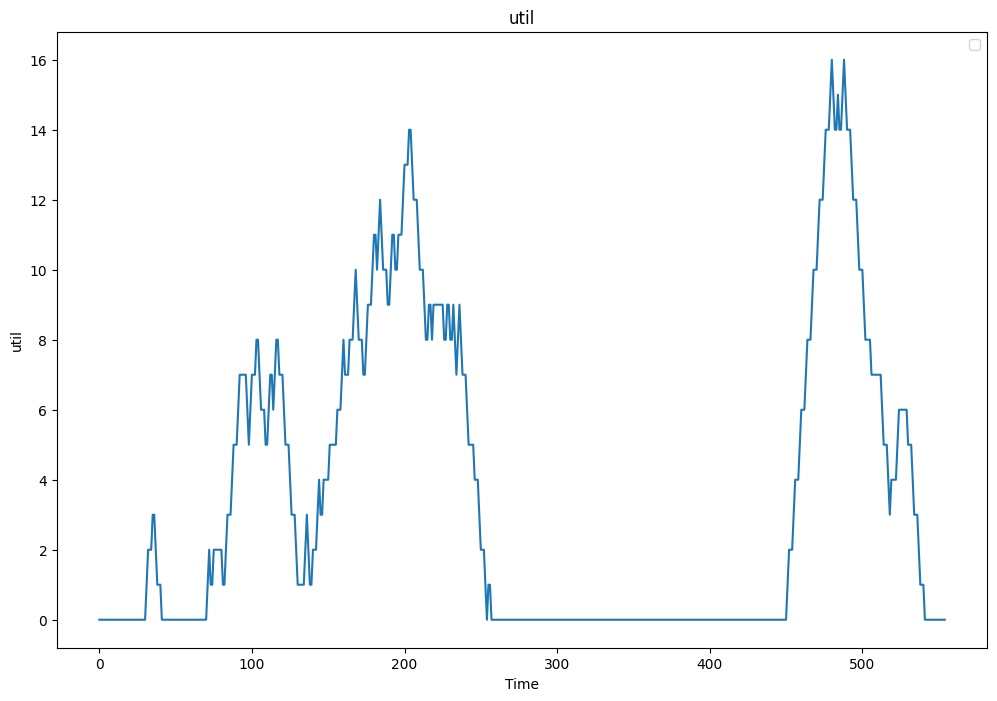

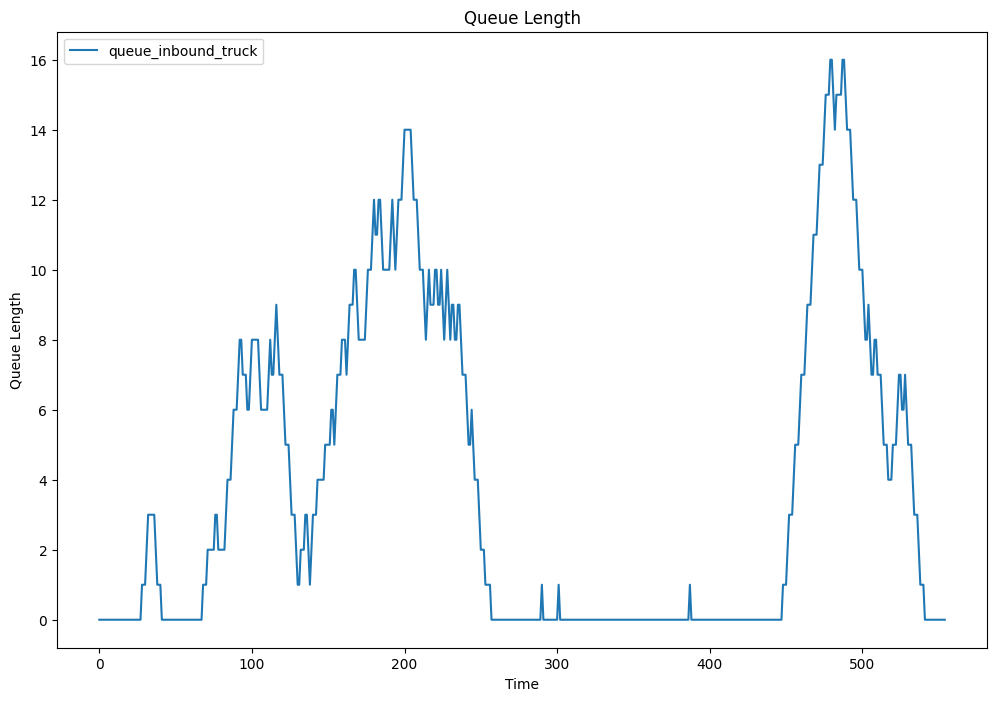

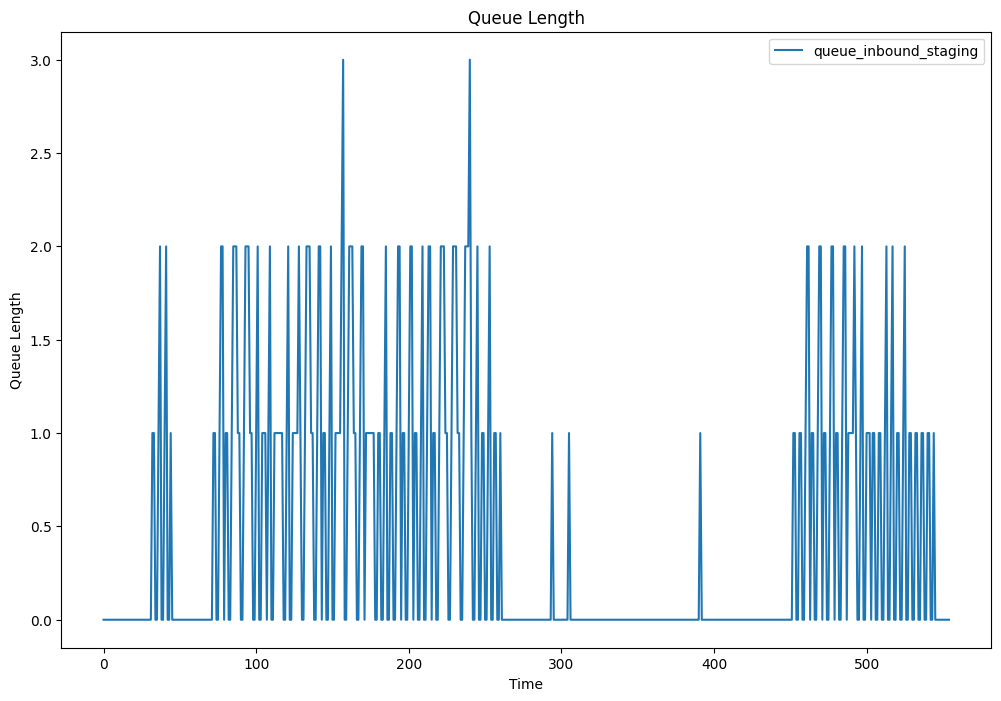

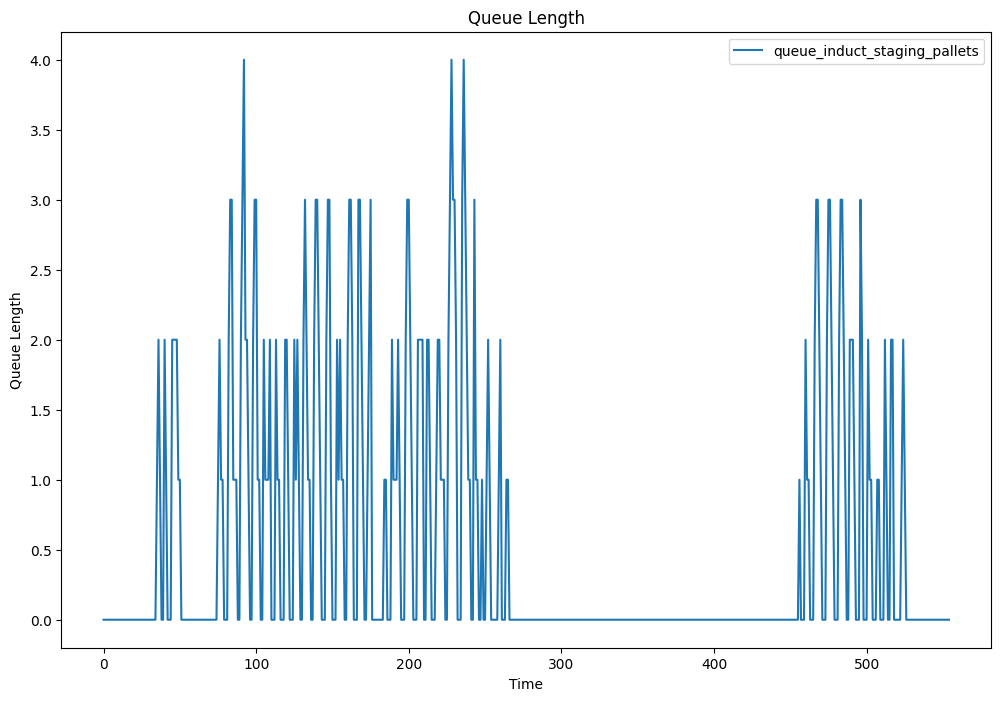

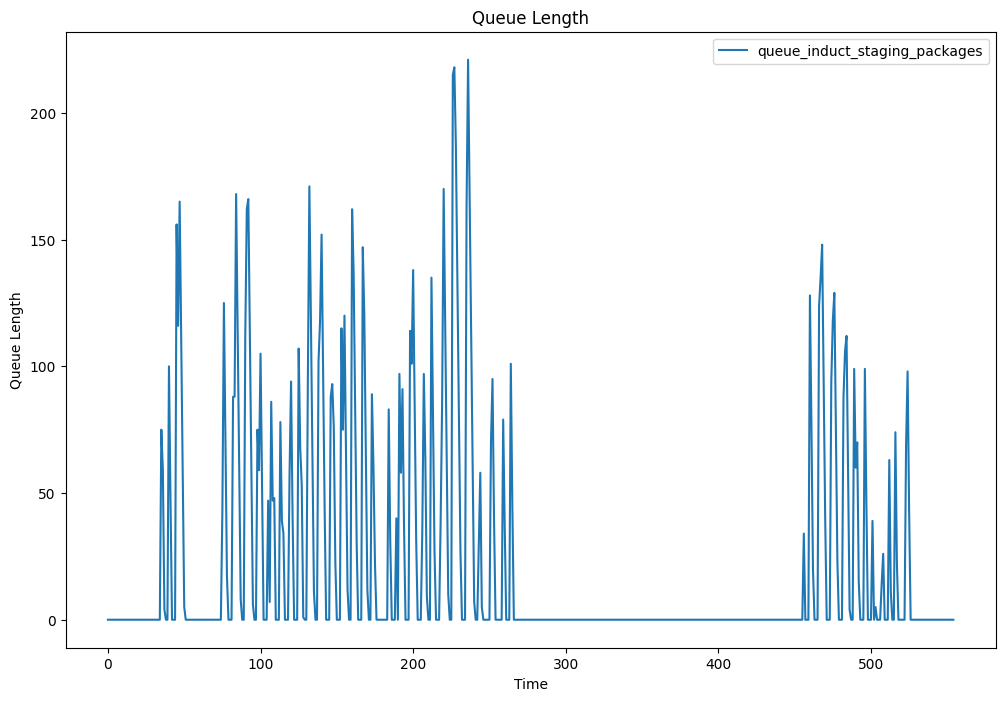

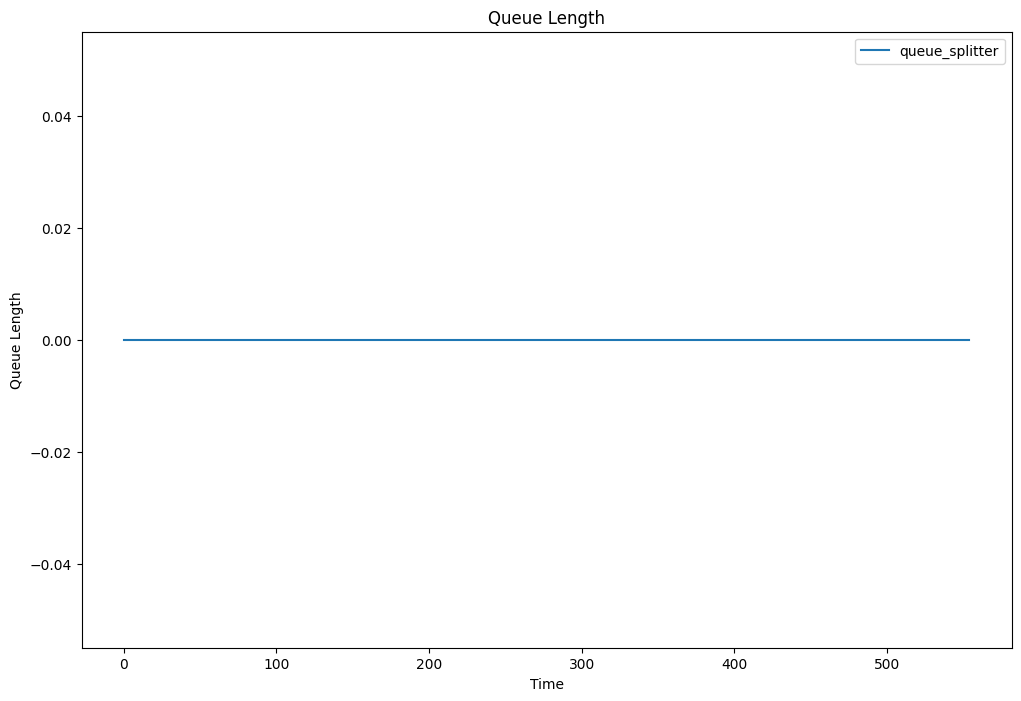

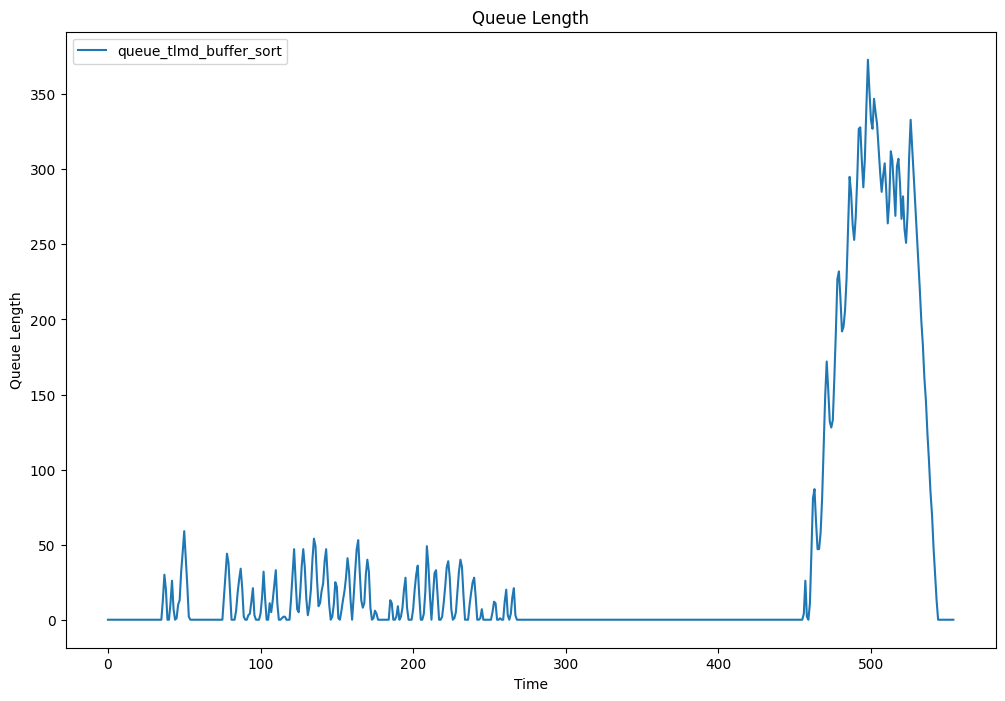

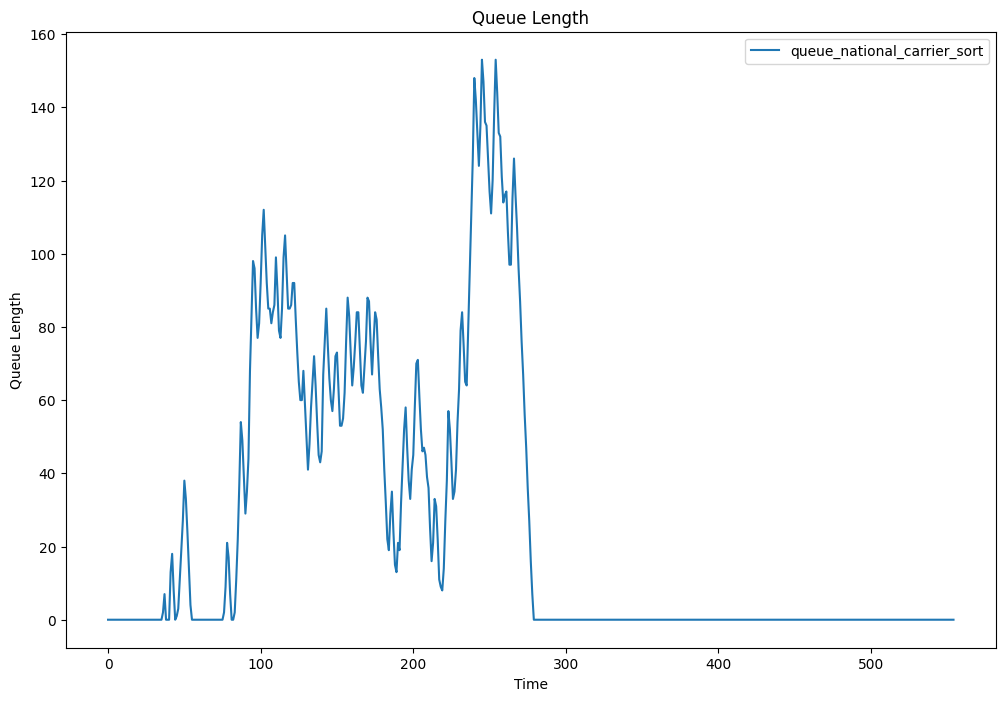

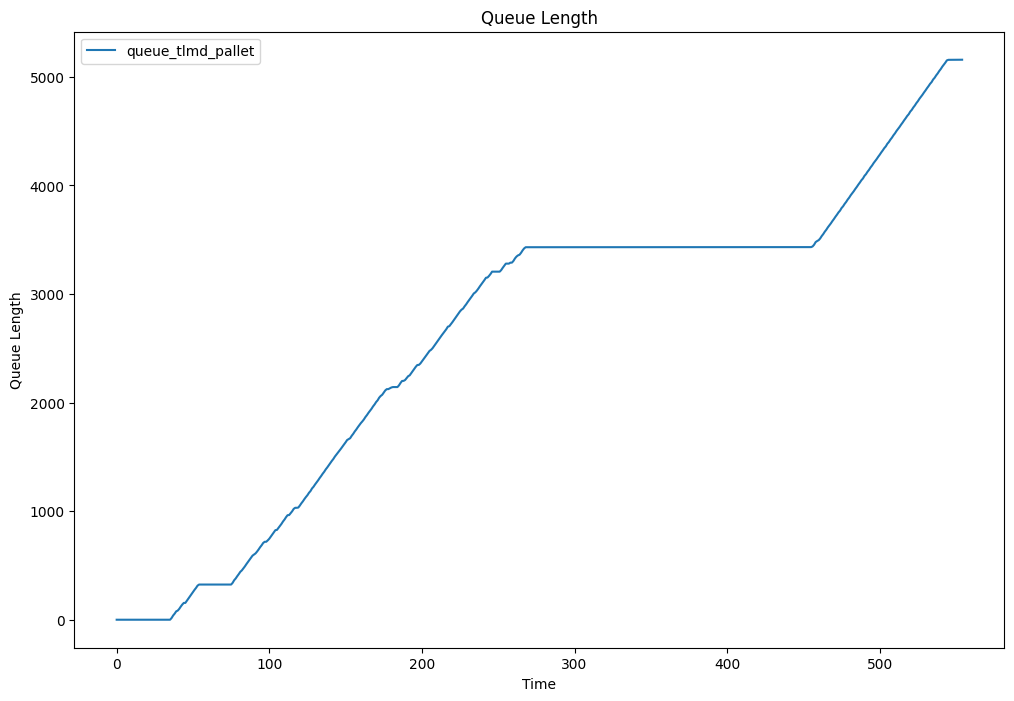

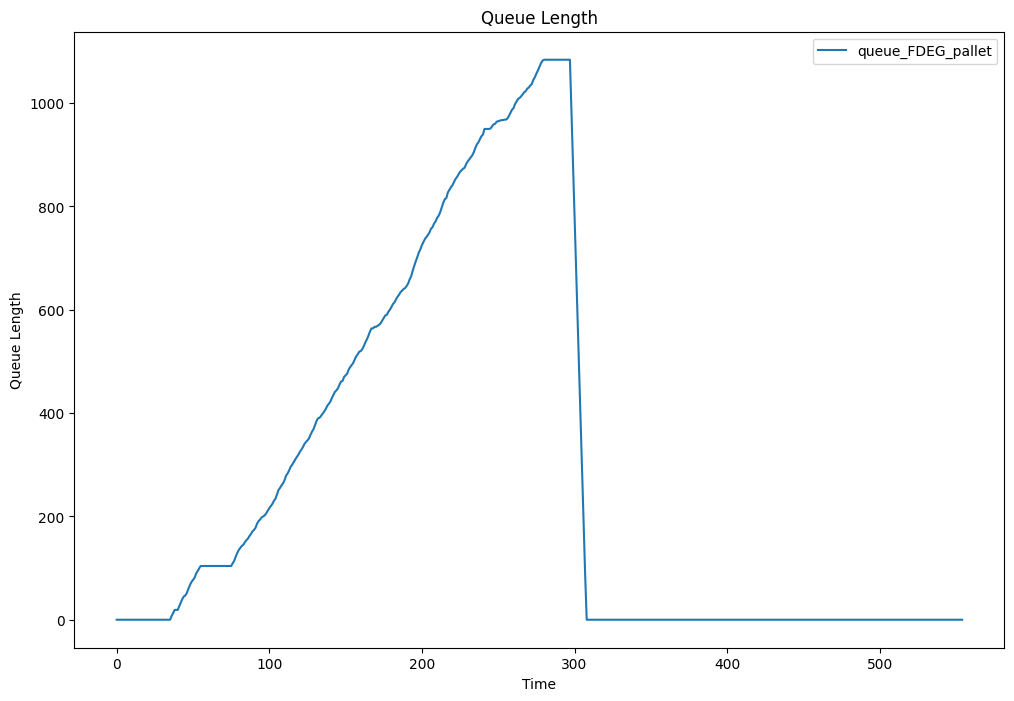

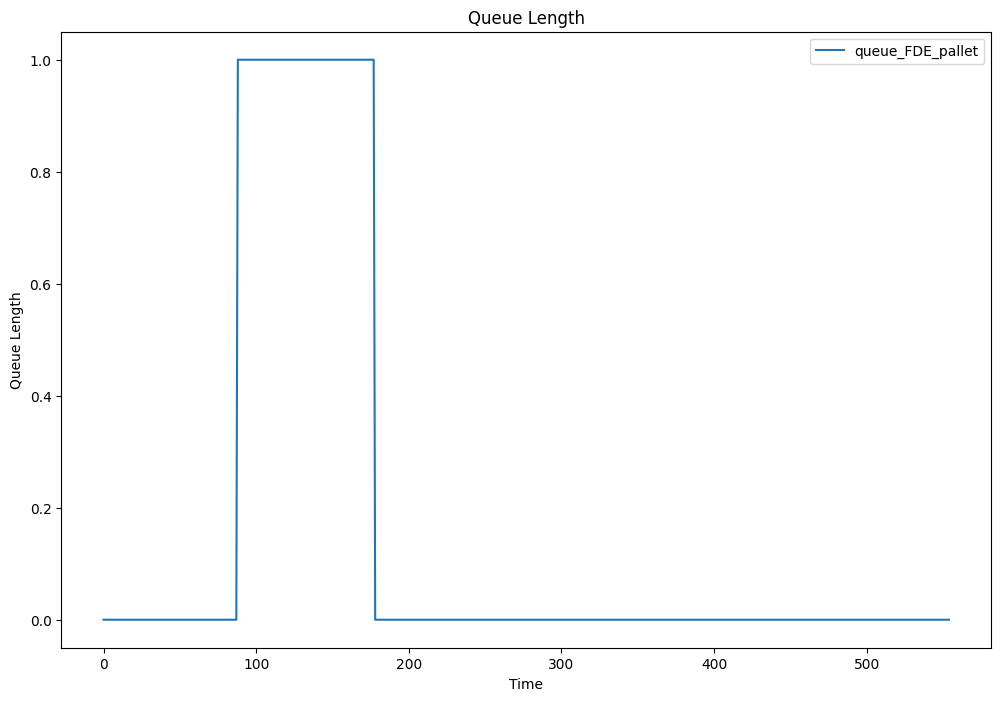

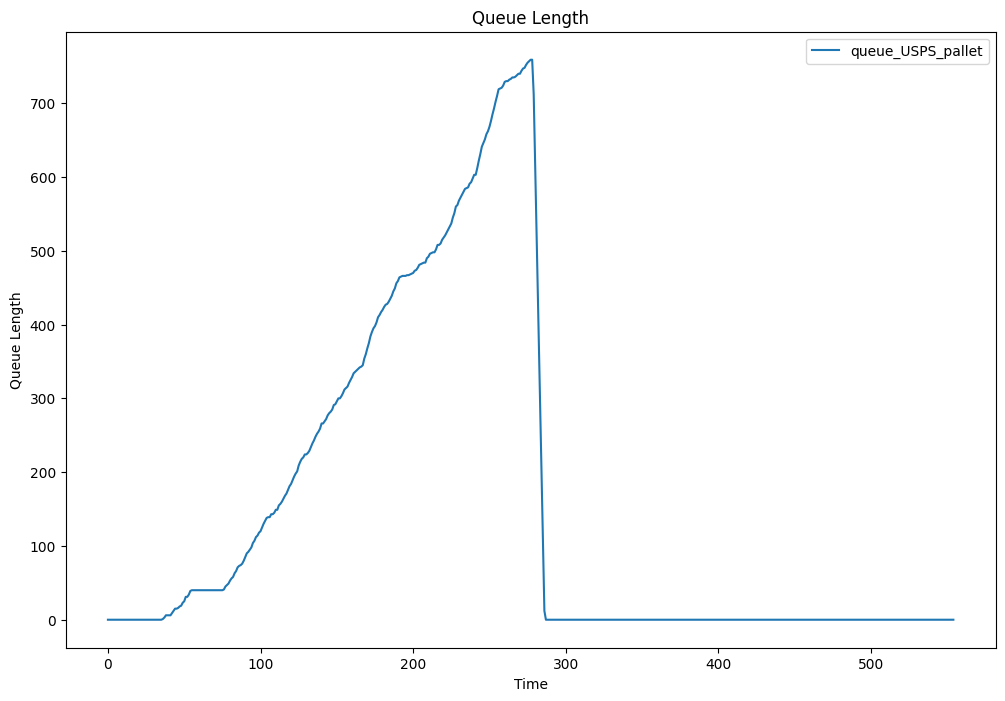

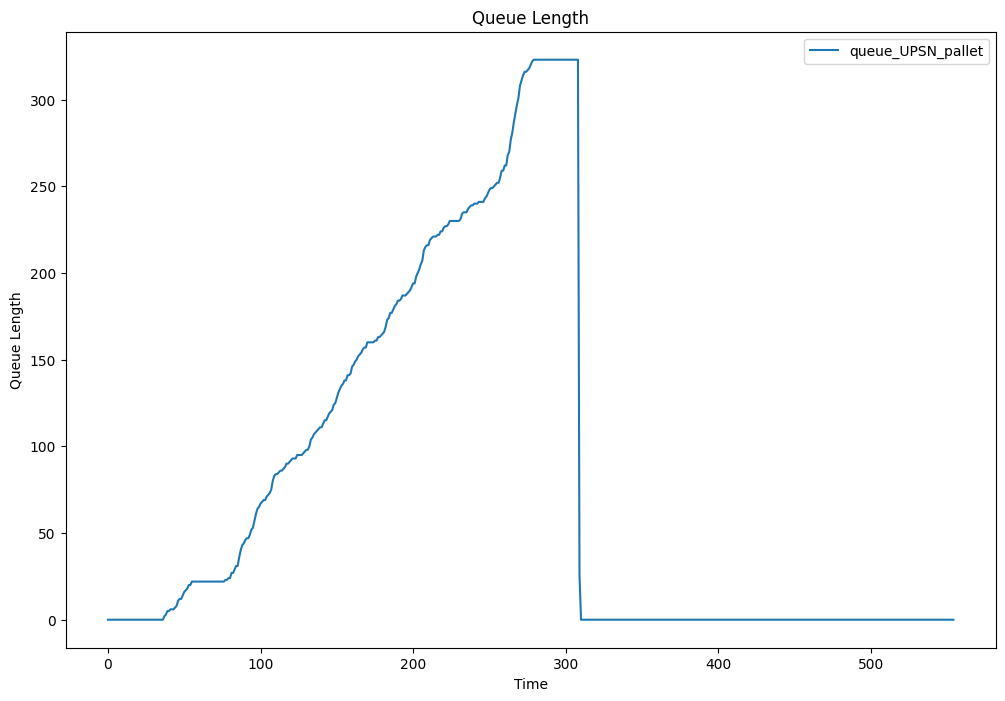

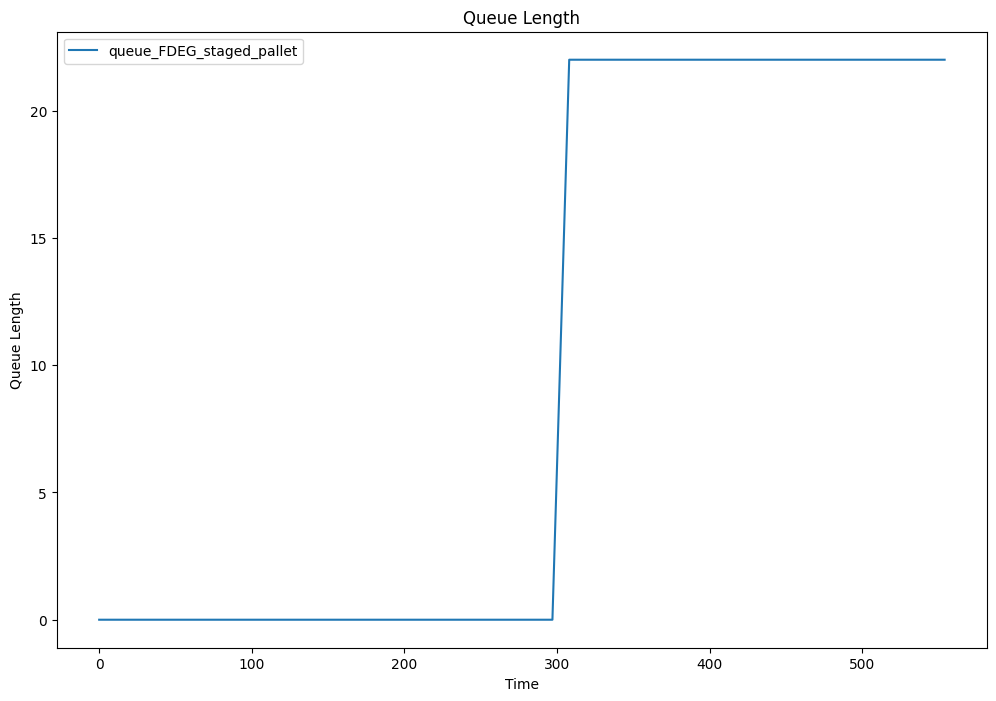

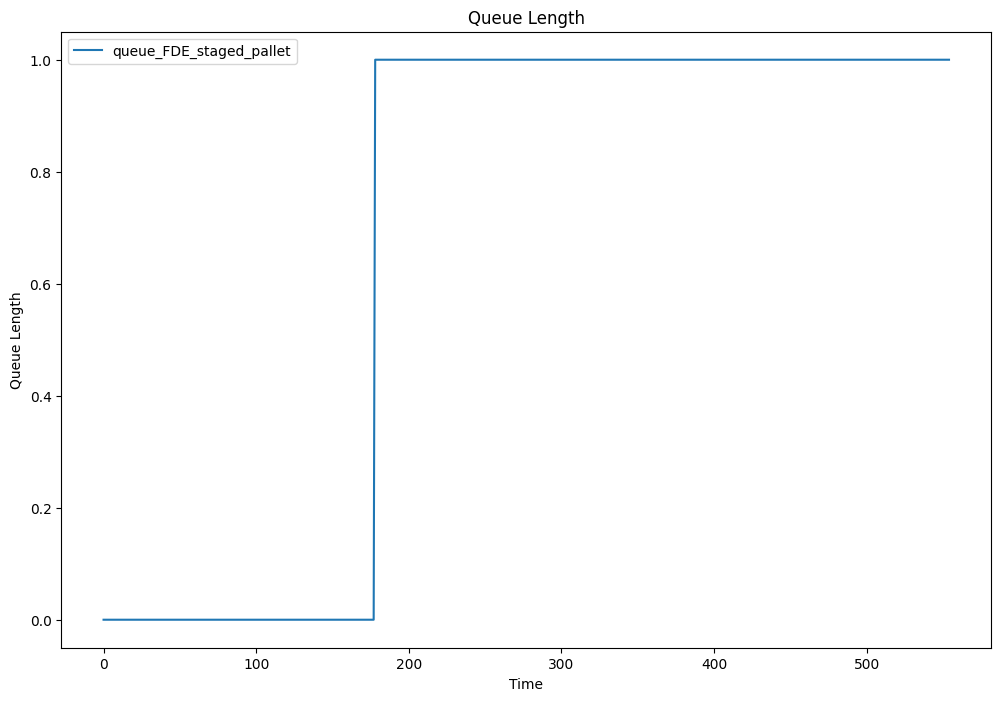

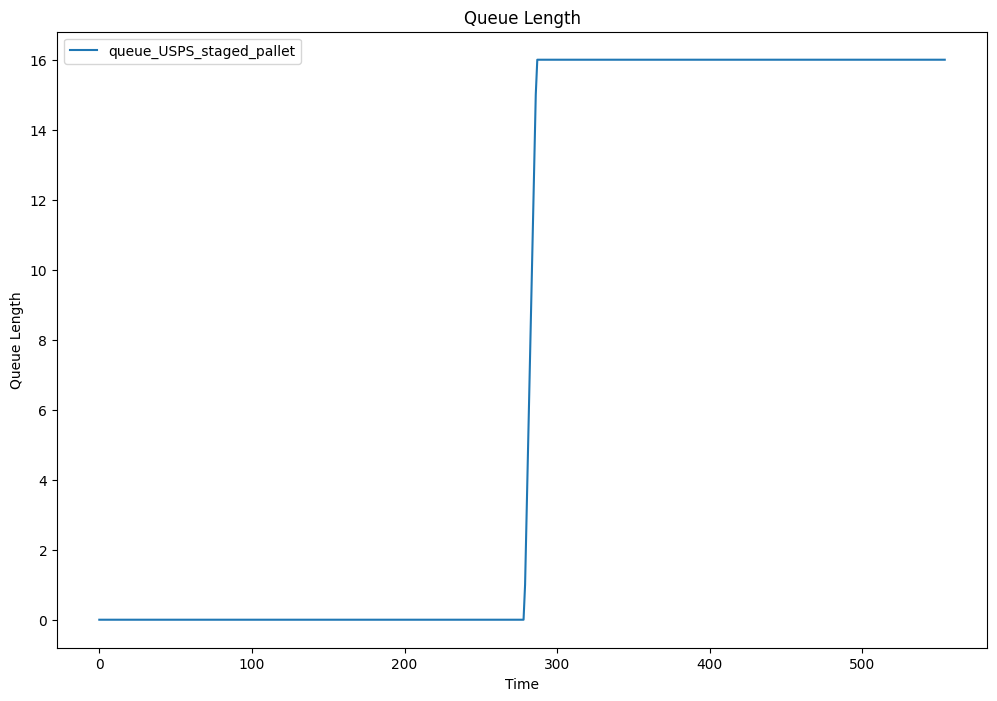

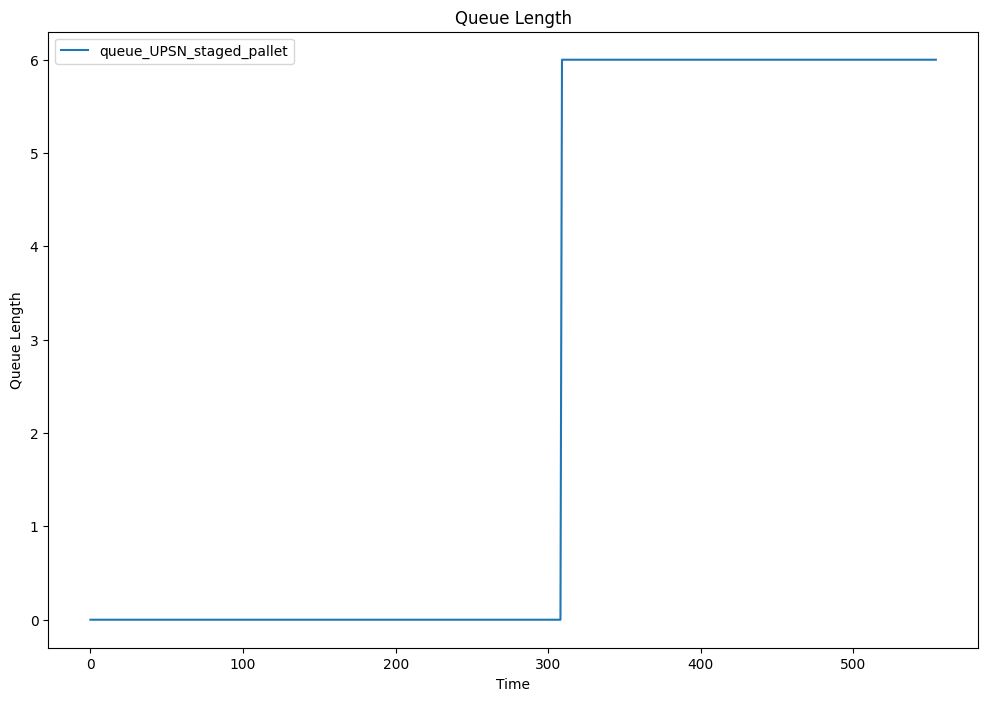

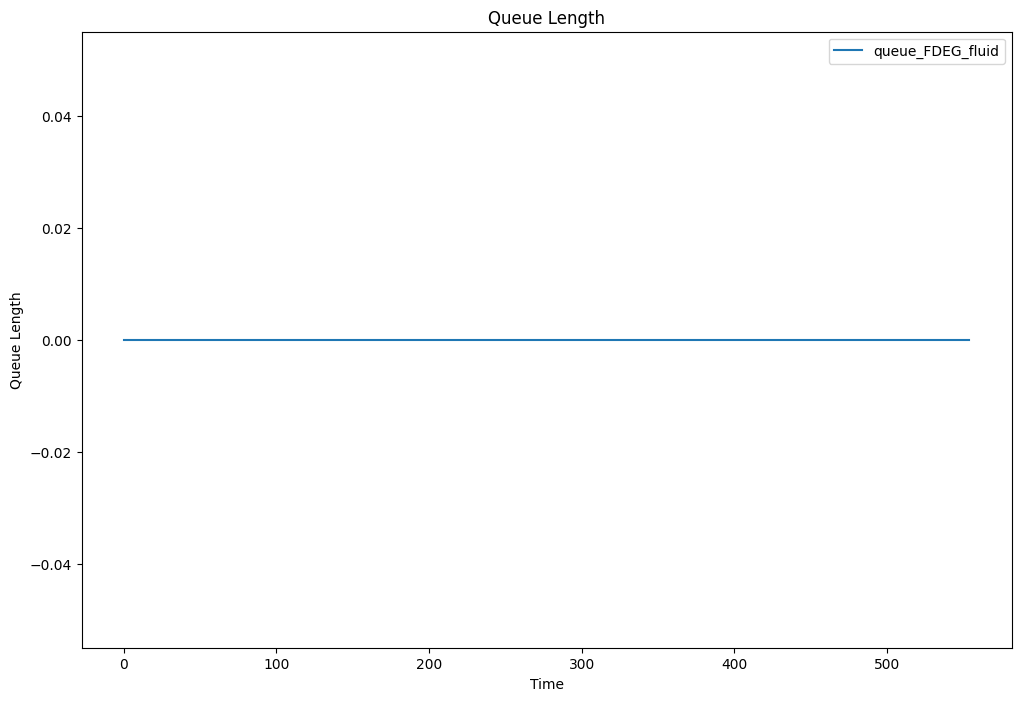

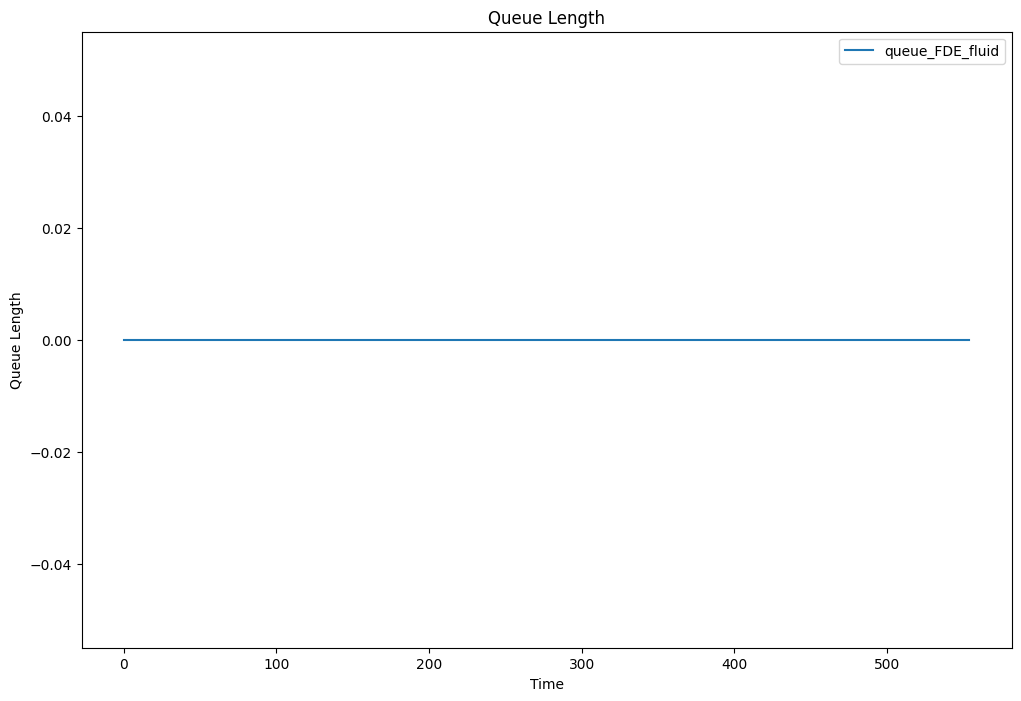

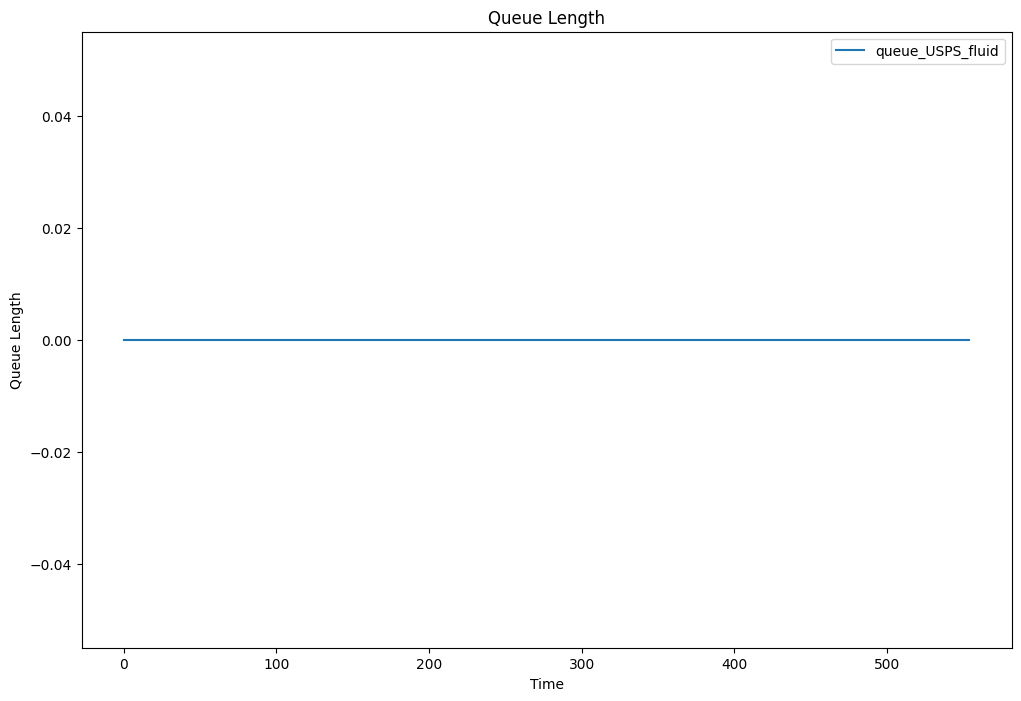

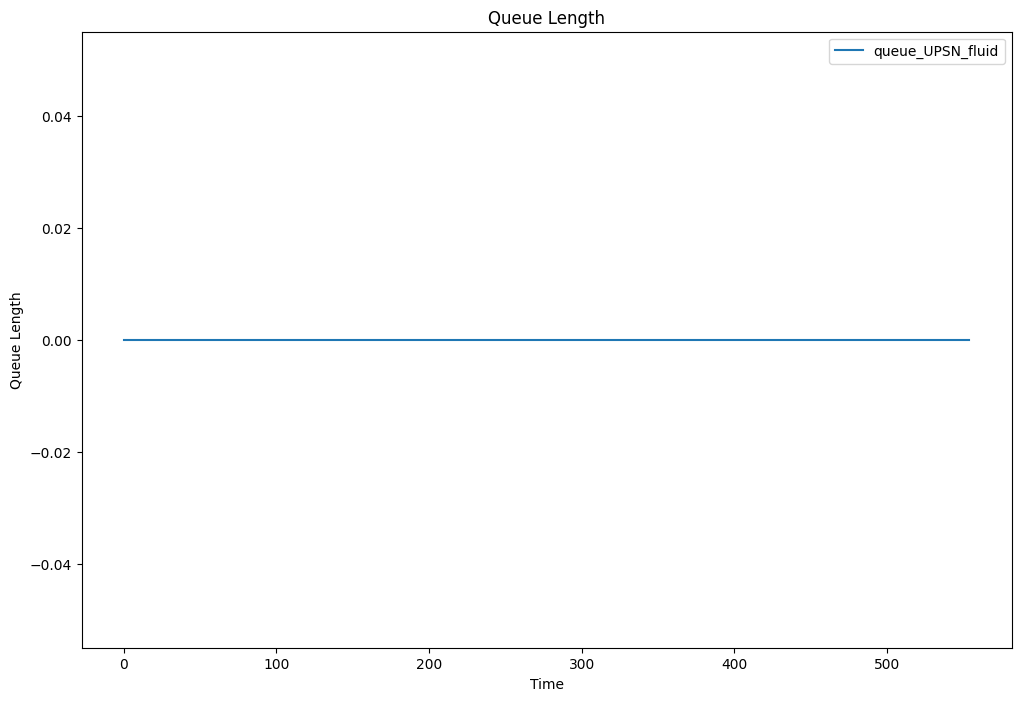

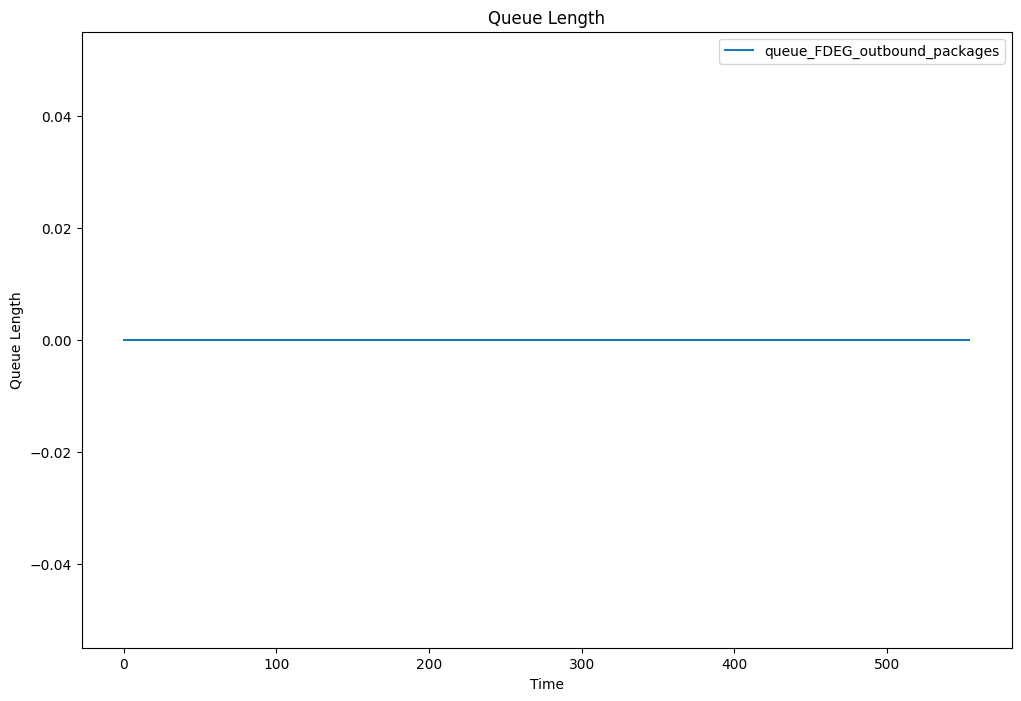

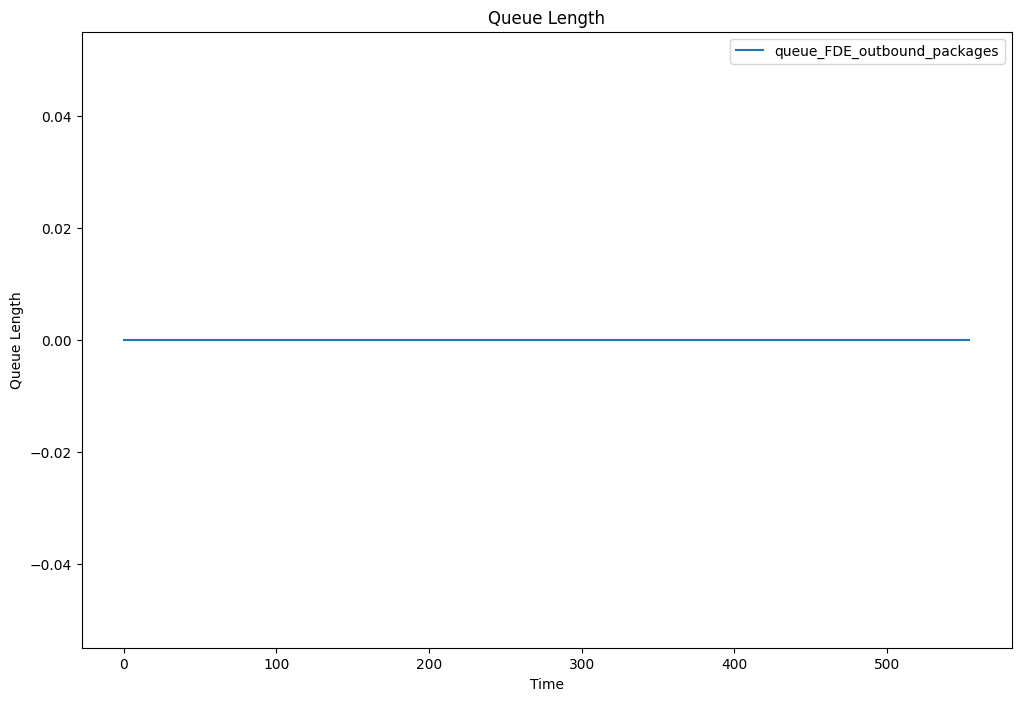

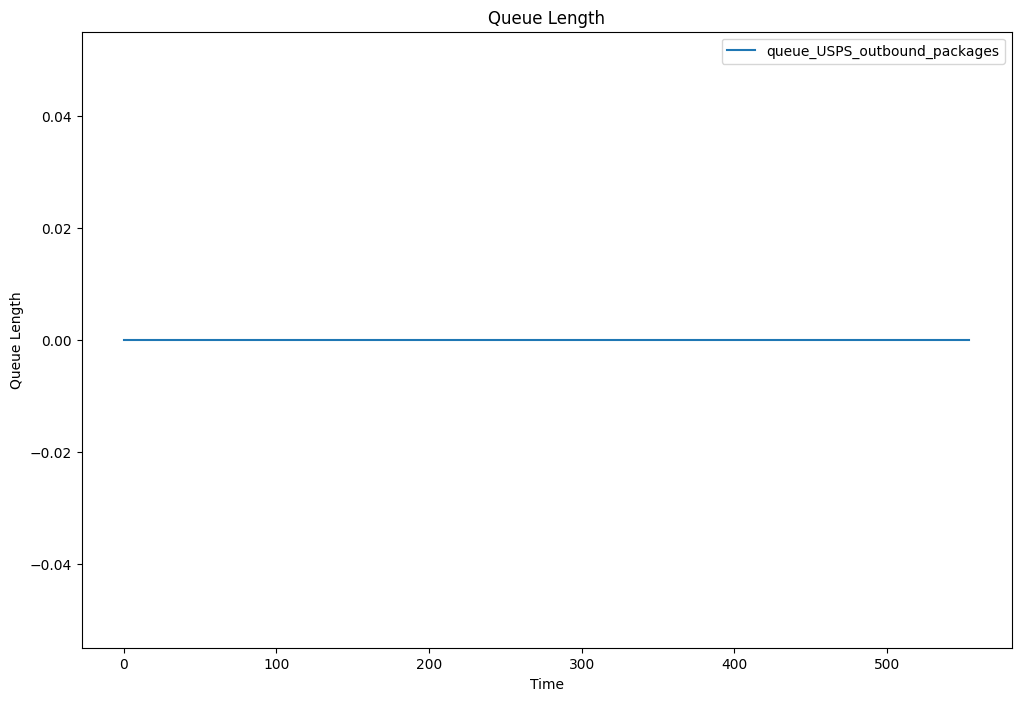

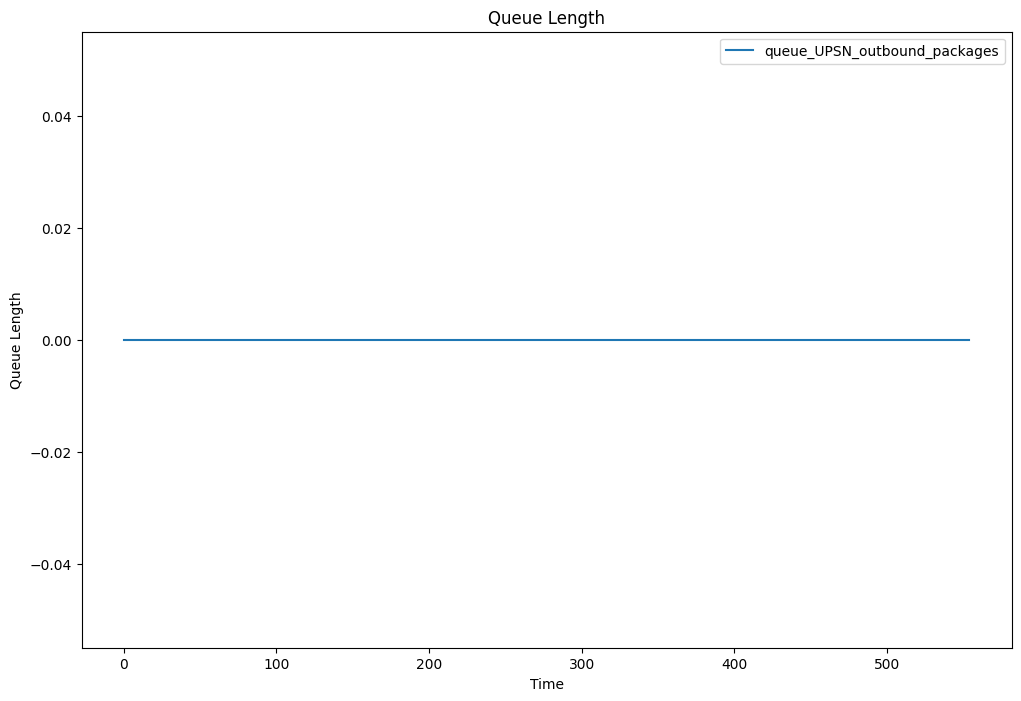

Total Packages to sort: 5158
Begin TLMD Sort Process
Partition 1: 2579 packages
Partition 2: 1805 packages
Partition 3: 774 packages
Total packages: 5158
TLMD Pallet_1 created with 50 packages at 0
TLMD Pallet_2 created with 50 packages at 0
TLMD Pallet_3 created with 50 packages at 0
TLMD Pallet_4 created with 50 packages at 0
TLMD Pallet_5 created with 50 packages at 0
TLMD Pallet_6 created with 50 packages at 0
TLMD Pallet_7 created with 50 packages at 0
TLMD Pallet_8 created with 50 packages at 0
TLMD Pallet_9 created with 50 packages at 0
TLMD Pallet_10 created with 50 packages at 0
TLMD Pallet_11 created with 50 packages at 0
TLMD Pallet_12 created with 50 packages at 0
TLMD Pallet_13 created with 50 packages at 0
TLMD Pallet_14 created with 50 packages at 0
TLMD Pallet_15 created with 50 packages at 0
TLMD Pallet_16 created with 50 packages at 0
TLMD Pallet_17 created with 50 packages at 0
TLMD Pallet_18 created with 50 packages at 0
TLMD Pallet_19 created with 50 packages at 0


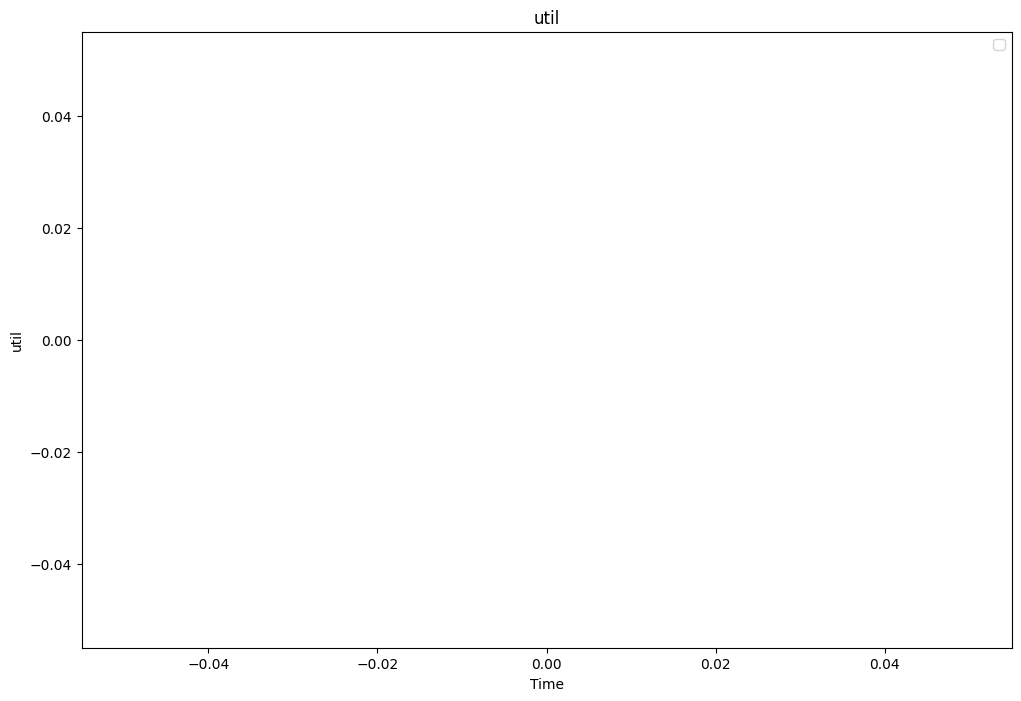

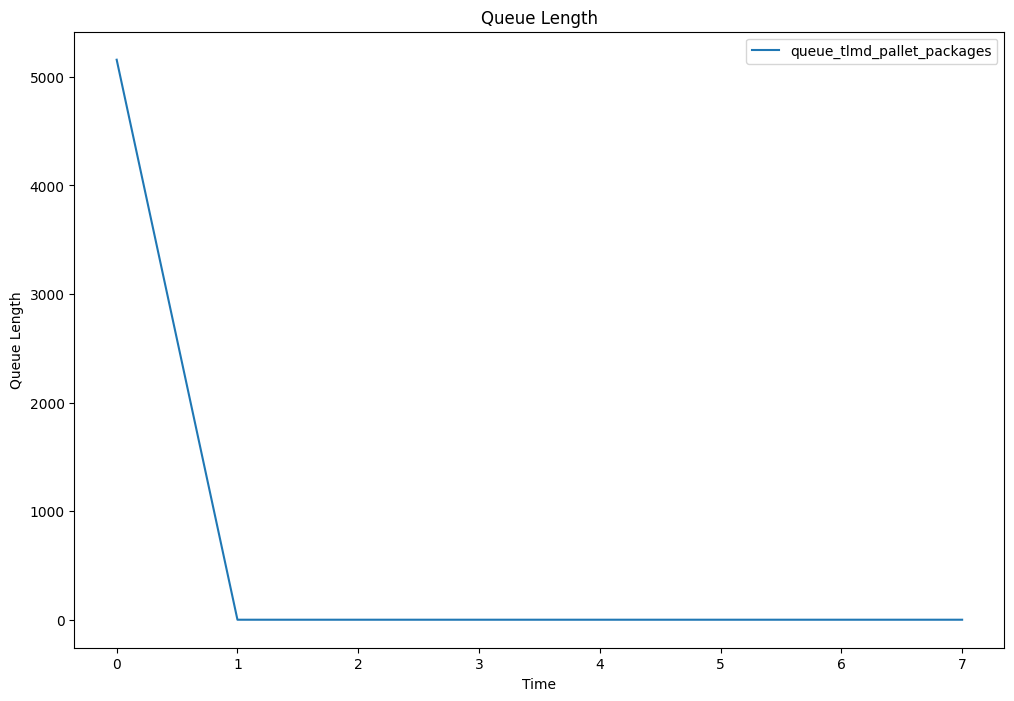

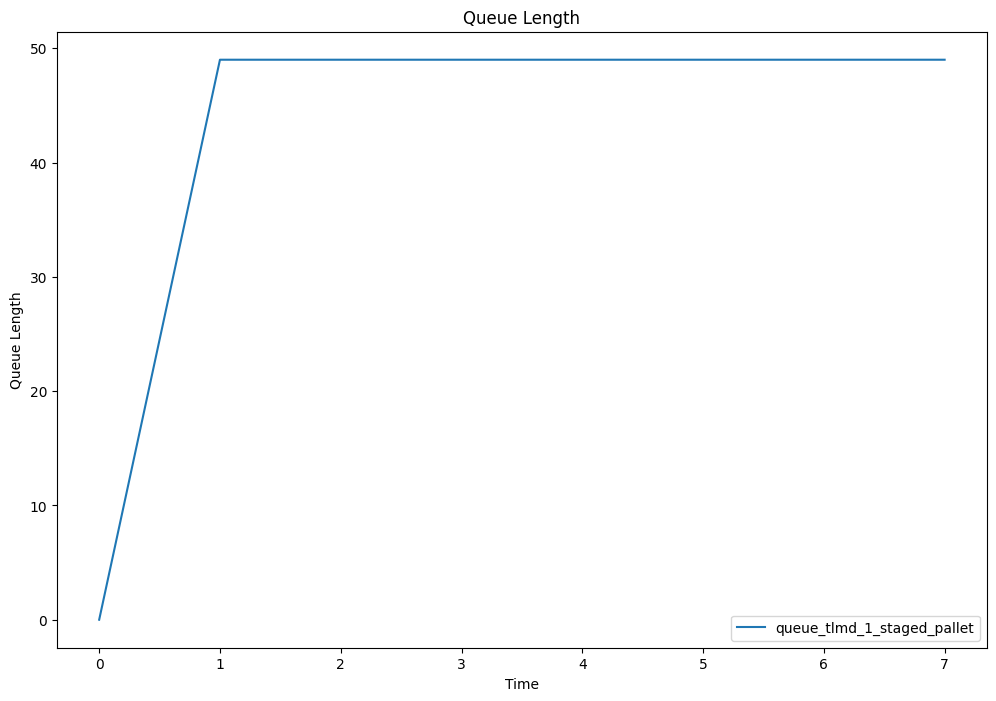

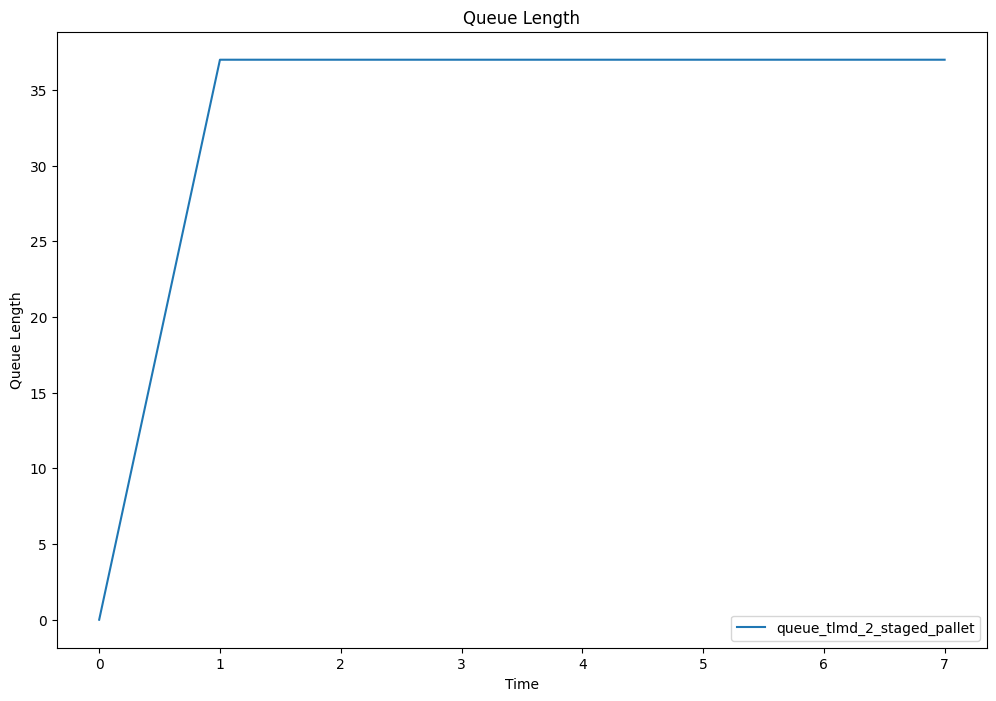

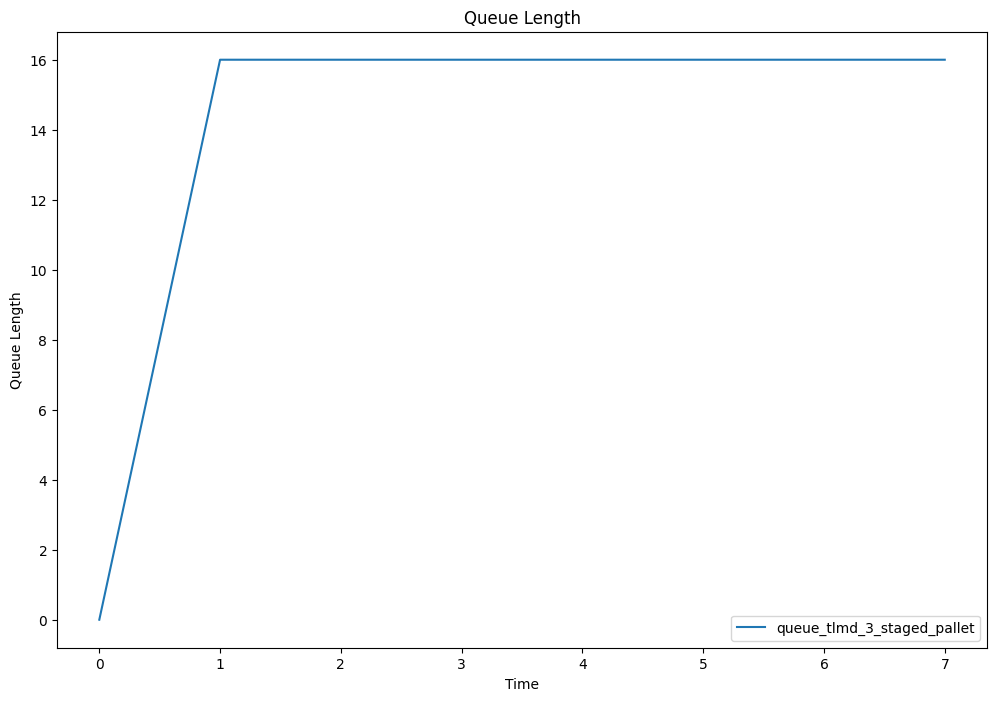

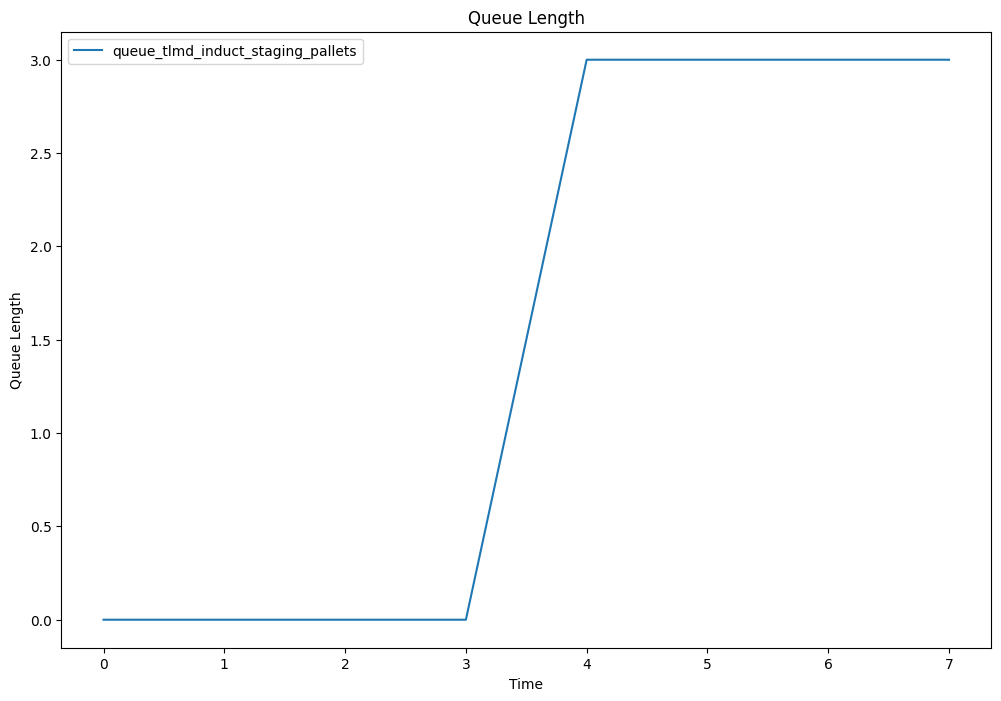

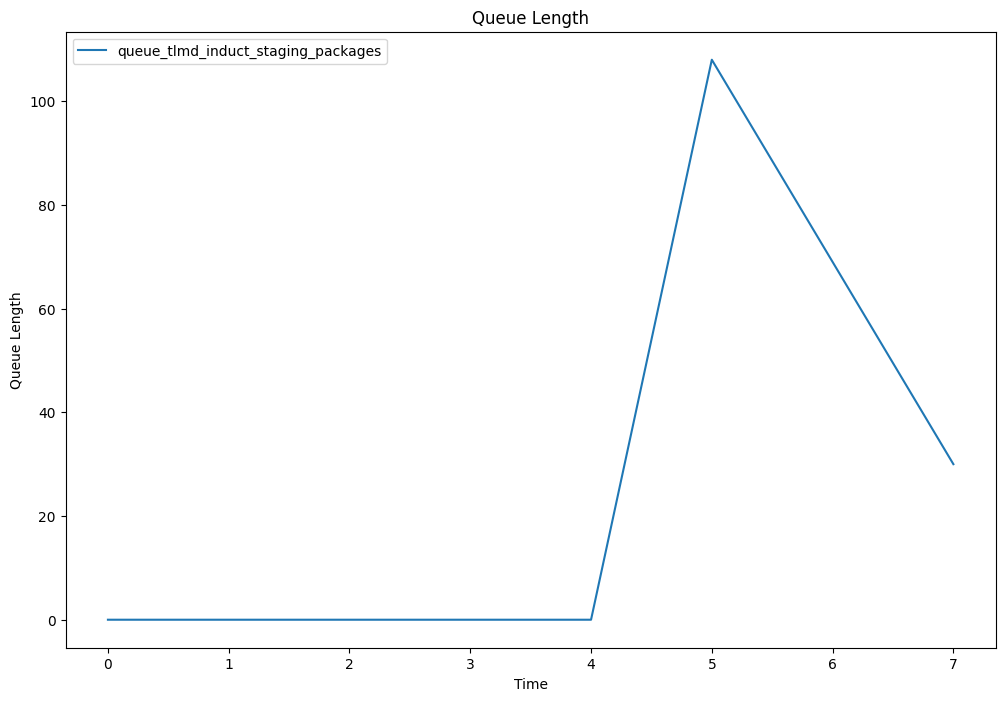

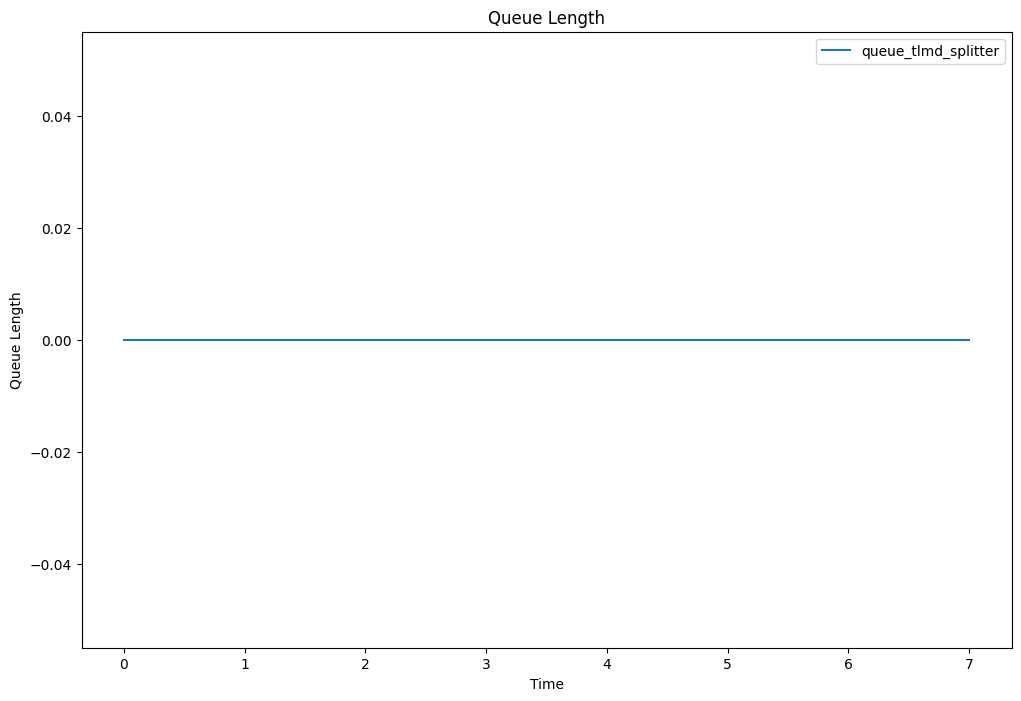

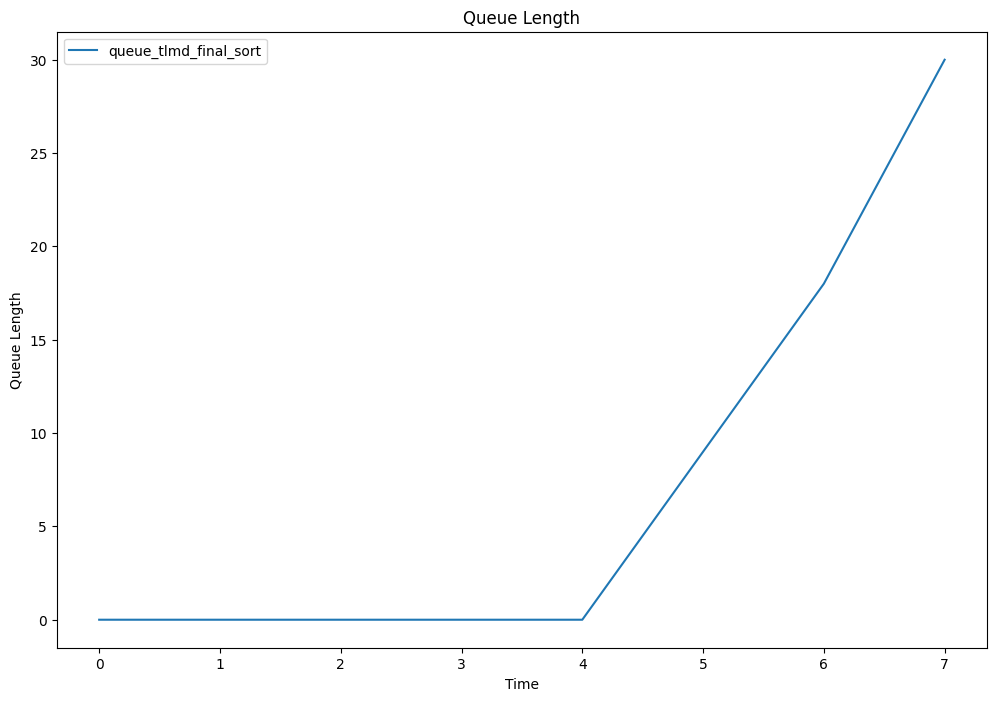

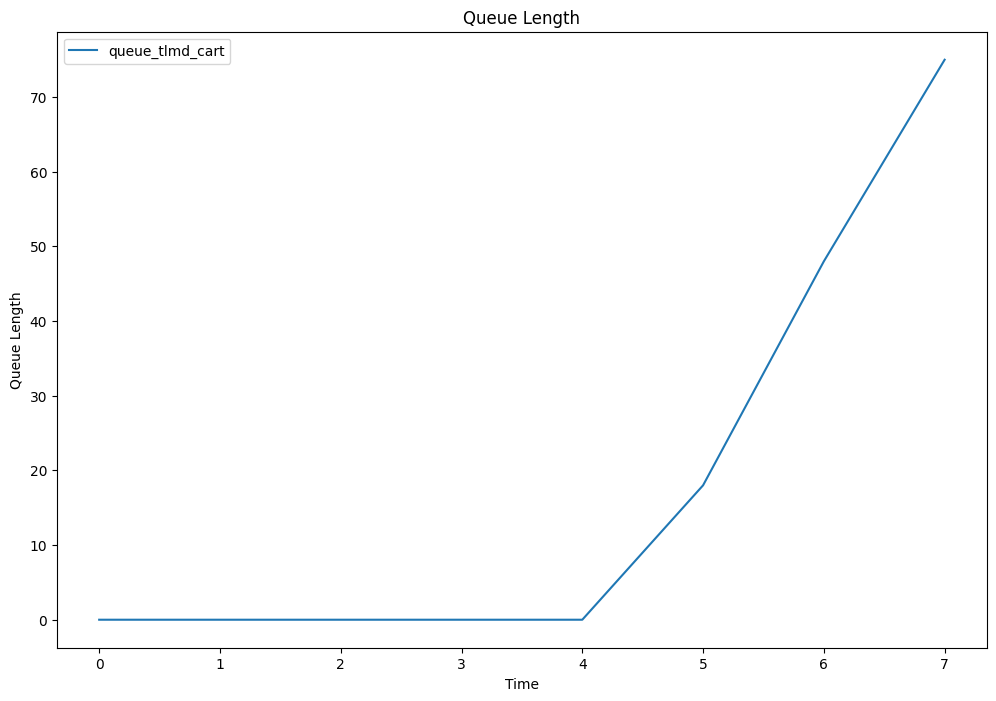

Night Shift over before full sortation completed
Induct Line Run as Batch Process:
...................................
Induct process completed at 547.2076781326782
UPSN Packages staged for handoff at 308.20767813267815
USPS Packages staged for handoff at 278.5903562653608
FDEG Packages staged for handoff at 297.20767813267815
FDE Packages staged for handoff at 177.93022113022263
Total packages remaining as WIP: 39
Remaining Partion 1 pallets: 46
Partition 1 packages remaining: 2318
Remaining Partion 2 pallets: 37
Partition 2 packages remaining: 1805
Remaining Partion 3 pallets: 16
Partition 3 packages remaining: 774
Total packages remaining at end of shift: 4897


In [4]:
if __name__ == '__main__':
    # Create a sample dataframe for package arrival data
    csv_path = 'package_arrivals721.csv'
    df = pd.read_csv(csv_path)

    pallet_info = df.groupby('Pallet').agg(
        num_packages=('package_tracking_number', 'count'),
        earliest_arrival=('pkg_received_utc_ts', 'min'),
        packages=('package_tracking_number', lambda x: list(zip(x, df.loc[x.index, 'scac'])))
    ).reset_index()
    
    nights_total_tm = 19

    #DAYS INBOUND INDUCT ALLOCATION
    night_tm_pit_unload = 2 
    night_tm_pit_induct = 4
    night_tm_nonpit_split = 1
    night_tm_nonpit_NC = 4
    night_tm_nonpit_buffer = 8

    #NIGHTS TLMD SORT ALLOCATION
    night_tm_TLMD_induct = 3
    night_tm_TLMD_picker = 4
    night_tm_TLMD_sort = 12

    #NIGHTS TLMD STAGE ALLOCATION
    night_tm_stage = 19
    night_tm_handoff = 19

    if night_tm_pit_unload + night_tm_pit_induct + night_tm_nonpit_split + night_tm_nonpit_NC + night_tm_nonpit_buffer > nights_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')   
    
    if night_tm_TLMD_induct + night_tm_TLMD_picker + night_tm_TLMD_sort  >  nights_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')

    if night_tm_stage > nights_total_tm or night_tm_handoff > nights_total_tm:
        raise ValueError('Total number of TMs exceeds the limit')
    
    unavailable_periods = [
        #(180, 210),  # Night shift bk1
        #(420, 435),  # Night shift bk2
        #(800, 810),  # Night shift shift gap
        #(990, 1020),  # Day shift break 1
        #(1230, 1245),  # Day shift break 2
        #(1410, 1440)  # Day shift shift gap
    ]

    # Setup inbound induct simulation
    env, sortation_center = setup_simulation(pallet_info, night_tm_pit_unload, night_tm_pit_induct, night_tm_nonpit_split, night_tm_nonpit_NC, night_tm_nonpit_buffer, unavailable_periods)

    # Run inbound induct simulation
    print("Begin Induct Process")
    env.run(until=555)
    print("End Induct Process")
    print(len(G.TLMD_STAGED_PACKAGES))
    plot_metrics(sortation_center.metrics)

    # Setup TLMD Sort simulation
    env, sortation_center = setup_simulation_2(G.TLMD_STAGED_PACKAGES, night_tm_TLMD_induct, night_tm_TLMD_picker, night_tm_TLMD_sort, unavailable_periods)
    if G.TLMD_INDUCT_TIME < 555:
        print('Begin TLMD Sort Process')
        env.run(until=(555-G.TLMD_INDUCT_TIME))
    print('End TLMD Sort Process')
    plot_metrics(sortation_center.metrics)

    #Determine if process is complete for the conduct of staging/handoff
    if len(G.PASSED_OVER_PALLETS_1)>0 or len(G.PASSED_OVER_PALLETS_2)>0 or len(G.PASSED_OVER_PALLETS_3)>0:
        print("Night Shift over before full sortation completed")
        print(f'Induct Line Run as Batch Process:')
        print("...................................")
        print(f'Induct process completed at {G.TLMD_INDUCT_TIME}')
        print(f'UPSN Packages staged for handoff at {G.UPSN_SORT_TIME}')
        print(f'USPS Packages staged for handoff at {G.USPS_SORT_TIME}')
        print(f'FDEG Packages staged for handoff at {G.FDEG_SORT_TIME}')
        print(f'FDE Packages staged for handoff at {G.FDE_SORT_TIME}')
        total_packages = 0
        total_packages_1 = 0
        total_packages_2= 0
        total_packages_3 = 0
        for pallet in G.TLMD_INDUCT_STAGING_PALLETS_CARRYOVER.items:
            total_packages += pallet.current_packages
        for package in G.TLMD_INDUCT_STAGING_PACKAGES_CARRYOVER.items:
            total_packages += 1
        for package in G.TLMD_SPLITTER_CARRYOVER.items:   
            total_packages += 1
        for package in G.TLMD_FINAL_SORT_CARRYOVER.items:
            total_packages += 1
        print(f'Total packages remaining as WIP: {total_packages}')
        if len(G.PASSED_OVER_PALLETS_1)>0:
            print(f'Remaining Partion 1 pallets: {len(G.PASSED_OVER_PALLETS_1)}')
            
            for pallet in G.PASSED_OVER_PALLETS_1:  # Assuming pallets_list is your list of TLMD_Pallet objects
                total_packages_1 += pallet.current_packages
            print(f'Partition 1 packages remaining: {total_packages_1+total_packages}')
        if len(G.PASSED_OVER_PALLETS_2)>0:
            print(f'Remaining Partion 2 pallets: {len(G.PASSED_OVER_PALLETS_2)}')
            
            for pallet in G.PASSED_OVER_PALLETS_2:  # Assuming pallets_list is your list of TLMD_Pallet objects
                total_packages_2 += pallet.current_packages
            if len(G.PASSED_OVER_PALLETS_1)==0:
                print(f'Partition 2 packages remaining: {total_packages_2+total_packages}')
            else:
                print(f'Partition 2 packages remaining: {total_packages_2}')
        if len(G.PASSED_OVER_PALLETS_3)>0:
            print(f'Remaining Partion 3 pallets: {len(G.PASSED_OVER_PALLETS_3)}')
            
            for pallet in G.PASSED_OVER_PALLETS_3:  # Assuming pallets_list is your list of TLMD_Pallet objects
                total_packages_3 += pallet.current_packages
            if len(G.PASSED_OVER_PALLETS_2)==0:
                print(f'Partition 3 packages remaining: {total_packages_3+total_packages}')
            else:
                print(f'Partition 3 packages remaining: {total_packages_3}')

        G.TOTAL_SHIFT_PACKAGE_CARRYOVER = total_packages_1+total_packages_2+total_packages_3+total_packages
        print(f'Total packages remaining at end of shift: {G.TOTAL_SHIFT_PACKAGE_CARRYOVER}')
                    
    else:
        #########################################
        # Setup TLMD Stage and Handoff simulation
        #########################################
        env, sortation_center = setup_simulation_3(night_tm_stage, night_tm_handoff, unavailable_periods)
        print('Begin TLMD Stage Process')
        env.run(until=555)
        print('End TLMD Stage Process')
        plot_metrics(sortation_center.metrics)

    


In [5]:
print(f'Induct Line Run as Batch Process:')
print("...................................")
print(f'Induct process completed at {G.TLMD_INDUCT_TIME}')
print(f'UPSN Packages staged for handoff at {G.UPSN_SORT_TIME}')
print(f'USPS Packages staged for handoff at {G.USPS_SORT_TIME}')
print(f'FDEG Packages staged for handoff at {G.FDEG_SORT_TIME}')
print(f'FDE Packages staged for handoff at {G.FDE_SORT_TIME}')
print("...................................")
print(f'Begin TLMD Sort Process:')
print("...................................")
print(f'Partition 1 sort process completed at {G.TLMD_PARTITION_1_SORT_TIME}')
print(f'Partition 2 sort process completed at {G.TLMD_PARTITION_2_SORT_TIME}')
print(f'Partition 3 sort process completed at {G.TLMD_PARTITION_3_SORT_TIME}')
print(f'Partition 1 cart staging completed at {G.TLMD_PARTITION_1_CART_STAGE_TIME}')
print(f'Partition 2 cart staging completed at {G.TLMD_PARTITION_2_CART_STAGE_TIME}')
print(f'Partition 3 cart staging completed at {G.TLMD_PARTITION_3_CART_STAGE_TIME}')




Induct Line Run as Batch Process:
...................................
Induct process completed at 547.2076781326782
UPSN Packages staged for handoff at 308.20767813267815
USPS Packages staged for handoff at 278.5903562653608
FDEG Packages staged for handoff at 297.20767813267815
FDE Packages staged for handoff at 177.93022113022263
...................................
Begin TLMD Sort Process:
...................................
Partition 1 sort process completed at None
Partition 2 sort process completed at None
Partition 3 sort process completed at None
Partition 1 cart staging completed at None
Partition 2 cart staging completed at None
Partition 3 cart staging completed at None
